In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#downloading the dataset 2048
url = "https://drive.google.com/u/0/uc?id=1MaFmKMfEXPr9yuFGu_Ff9wV-3SlmC3Nz&export=download"
output = "data_2048.zip"
gdown.download(url, output)
!unzip data_2048.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1MaFmKMfEXPr9yuFGu_Ff9wV-3SlmC3Nz&export=download
From (redirected): https://drive.google.com/uc?id=1MaFmKMfEXPr9yuFGu_Ff9wV-3SlmC3Nz&export=download&confirm=t&uuid=cfda7bfd-5190-41fe-91d3-d3cc7b4a6a7d
To: /content/data_2048.zip
100%|██████████| 217M/217M [00:01<00:00, 168MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_2048/clean/images/1_1695.png  
  inflating: data_2048/clean/images/1_1696.png  
  inflating: data_2048/clean/images/1_1697.png  
  inflating: data_2048/clean/images/1_1710.png  
  inflating: data_2048/clean/images/1_1711.png  
  inflating: data_2048/clean/images/1_1712.png  
  inflating: data_2048/clean/images/1_1714.png  
  inflating: data_2048/clean/images/1_1715.png  
  inflating: data_2048/clean/images/1_1716.png  
  inflating: data_2048/clean/images/1_1719.png  
  inflating: data_2048/clean/images/1_1723.png  
  inflating: data_2048/clean/images/1_1724.png  
  inflating: data_2048/clean/images/1_1726.png  
  inflating: data_2048/clean/images/1_1727.png  
  inflating: data_2048/clean/images/1_1728.png  
  inflating: data_2048/clean/images/1_1737.png  
  inflating: data_2048/clean/images/1_1741.png  
  inflating: data_2048/clean/images/1_1744.png  
  inflating: data_2048/clean/images/1_1745.png  
  inflating: data_2

In [8]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_2048")):
  print(folder)
  for im in tqdm(os.listdir("data_2048/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

jammed_channel



 25%|██▌       | 1/4 [00:03<00:09,  3.22s/it]

test



 50%|█████     | 2/4 [00:08<00:09,  4.72s/it]

clean



 75%|███████▌  | 3/4 [00:32<00:13, 13.35s/it]

clean_validation



100%|██████████| 4/4 [00:35<00:00,  8.96s/it]


In [9]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [10]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



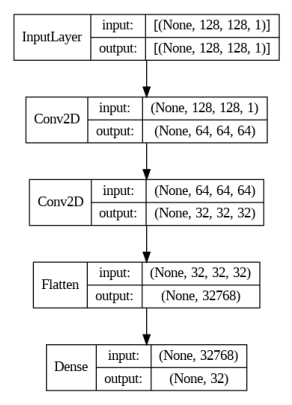

Summary of the decoder:



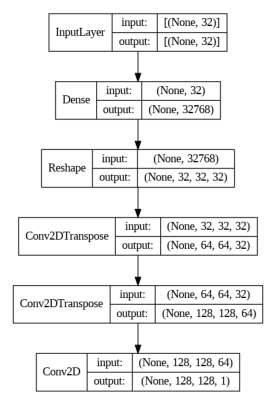

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [12]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 19s 52ms/step - loss: 0.0552 - val_loss: 0.0463
Epoch 2/20
125/125 [==============================] - 6s 49ms/step - loss: 0.0459 - val_loss: 0.0452
Epoch 3/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0416 - val_loss: 0.0364
Epoch 4/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0355 - val_loss: 0.0347
Epoch 5/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0348 - val_loss: 0.0345
Epoch 6/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0347 - val_loss: 0.0343
Epoch 7/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0346 - val_loss: 0.0342
Epoch 8/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0345 - val_loss: 0.0342
Epoch 9/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0345 - val_loss: 0.0341
Epoch 10/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0344 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

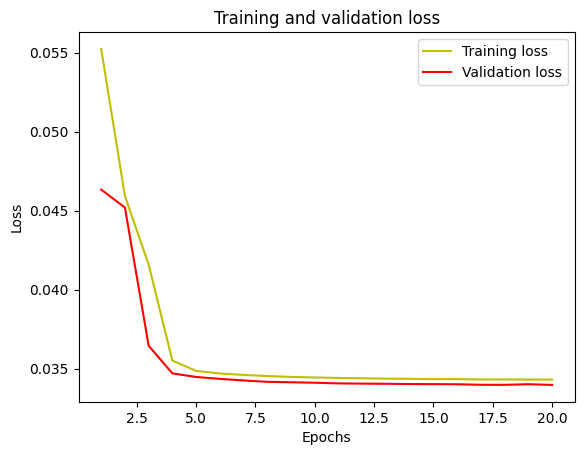

In [13]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 20ms/step


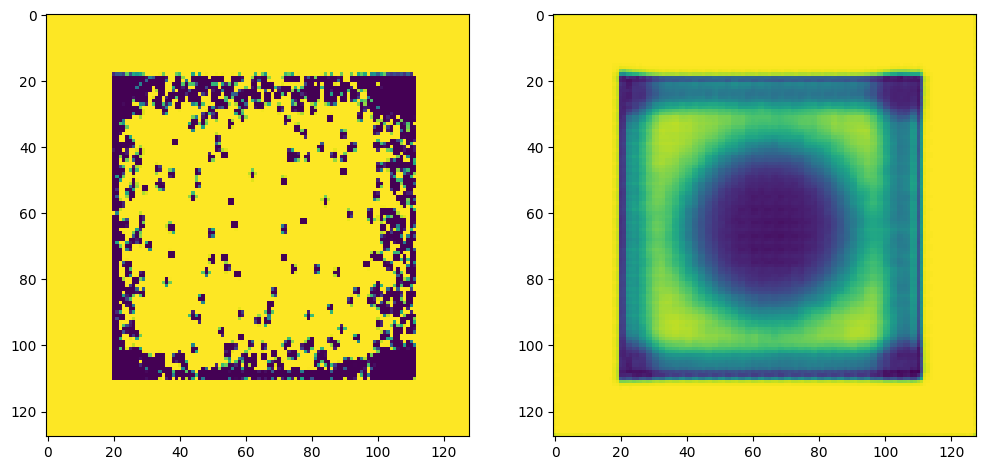

In [16]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [17]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 57ms/step - loss: 0.0625
Validation error 0.03396117687225342
Anomaly error 0.06245449185371399
The reconstruction error of the jammed channel is  1.8389966899156507  more than the clean channel


In [18]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [19]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 225ms/step - loss: 0.0350


  0%|          | 1/600 [00:00<04:18,  2.31it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0340


  0%|          | 2/600 [00:00<03:14,  3.08it/s]

1/1 [==============================] - 0s 82ms/step - loss: 0.0332


  0%|          | 3/600 [00:00<02:34,  3.86it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0331


  1%|          | 4/600 [00:01<02:18,  4.30it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0336


  1%|          | 5/600 [00:01<01:54,  5.21it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0309


  1%|          | 6/600 [00:01<01:47,  5.51it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0322


  1%|          | 7/600 [00:01<01:45,  5.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0343


  1%|▏         | 8/600 [00:01<01:47,  5.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0352


  2%|▏         | 10/600 [00:01<01:17,  7.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0358


  2%|▏         | 12/600 [00:01<01:03,  9.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0307


  2%|▏         | 14/600 [00:02<00:55, 10.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0396


  3%|▎         | 16/600 [00:02<00:52, 11.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0330


  3%|▎         | 18/600 [00:02<00:49, 11.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0355


  3%|▎         | 20/600 [00:02<00:48, 11.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0354


  4%|▎         | 22/600 [00:02<00:46, 12.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0370


  4%|▍         | 24/600 [00:02<00:46, 12.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0320


  4%|▍         | 26/600 [00:03<00:43, 13.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0324


  5%|▍         | 28/600 [00:03<00:43, 13.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


  5%|▌         | 30/600 [00:03<00:42, 13.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


  5%|▌         | 32/600 [00:03<00:41, 13.64it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0319


  6%|▌         | 34/600 [00:03<00:41, 13.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0322


  6%|▌         | 36/600 [00:03<00:43, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0359


  6%|▋         | 38/600 [00:03<00:42, 13.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0370


  7%|▋         | 40/600 [00:04<00:42, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


  7%|▋         | 42/600 [00:04<00:40, 13.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0347


  7%|▋         | 44/600 [00:04<00:41, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0354


  8%|▊         | 46/600 [00:04<00:42, 13.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0277


  8%|▊         | 48/600 [00:04<00:41, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0347


  8%|▊         | 50/600 [00:04<00:42, 13.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0336


  9%|▊         | 52/600 [00:05<00:41, 13.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0308


  9%|▉         | 54/600 [00:05<00:40, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0340


  9%|▉         | 56/600 [00:05<00:40, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0326


 10%|▉         | 58/600 [00:05<00:38, 14.09it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0305


 10%|█         | 60/600 [00:05<00:42, 12.63it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0228


 10%|█         | 62/600 [00:05<00:47, 11.40it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0353


 11%|█         | 64/600 [00:06<00:49, 10.90it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0353


 11%|█         | 66/600 [00:06<00:50, 10.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0375


 11%|█▏        | 68/600 [00:06<00:50, 10.53it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0350


 12%|█▏        | 70/600 [00:06<00:52, 10.15it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0361


 12%|█▏        | 72/600 [00:06<00:56,  9.29it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0342


 12%|█▏        | 74/600 [00:07<00:55,  9.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0331


 12%|█▎        | 75/600 [00:07<00:54,  9.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0288


 13%|█▎        | 76/600 [00:07<00:54,  9.63it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0365


 13%|█▎        | 77/600 [00:07<00:56,  9.23it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0342


 13%|█▎        | 78/600 [00:07<00:56,  9.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0352


 13%|█▎        | 80/600 [00:07<00:53,  9.74it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0362


 14%|█▎        | 81/600 [00:07<00:54,  9.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0321


 14%|█▎        | 82/600 [00:07<00:54,  9.50it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0352


 14%|█▍        | 83/600 [00:08<00:54,  9.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0347


 14%|█▍        | 84/600 [00:08<00:54,  9.53it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0372


 14%|█▍        | 85/600 [00:08<00:53,  9.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0332


 14%|█▍        | 87/600 [00:08<00:46, 10.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0321


 15%|█▍        | 89/600 [00:08<00:43, 11.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0377


 15%|█▌        | 91/600 [00:08<00:41, 12.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0343


 16%|█▌        | 93/600 [00:08<00:40, 12.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 16%|█▌        | 95/600 [00:09<00:39, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


 16%|█▌        | 97/600 [00:09<00:37, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0323


 16%|█▋        | 99/600 [00:09<00:36, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0361


 17%|█▋        | 101/600 [00:09<00:36, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0298


 17%|█▋        | 103/600 [00:09<00:35, 13.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0382


 18%|█▊        | 105/600 [00:09<00:36, 13.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0324


 18%|█▊        | 107/600 [00:09<00:38, 12.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0347


 18%|█▊        | 109/600 [00:10<00:37, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0306


 18%|█▊        | 111/600 [00:10<00:37, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0326


 19%|█▉        | 113/600 [00:10<00:37, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


 19%|█▉        | 115/600 [00:10<00:37, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0343


 20%|█▉        | 117/600 [00:10<00:37, 12.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0303


 20%|█▉        | 119/600 [00:10<00:36, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0354


 20%|██        | 121/600 [00:10<00:37, 12.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0350


 20%|██        | 123/600 [00:11<00:36, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0289


 21%|██        | 125/600 [00:11<00:36, 13.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0335


 21%|██        | 127/600 [00:11<00:35, 13.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0324


 22%|██▏       | 129/600 [00:11<00:35, 13.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0315


 22%|██▏       | 131/600 [00:11<00:36, 12.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0327


 22%|██▏       | 133/600 [00:11<00:36, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0358


 22%|██▎       | 135/600 [00:12<00:36, 12.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0345


 23%|██▎       | 137/600 [00:12<00:35, 12.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0328


 23%|██▎       | 139/600 [00:12<00:35, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0327


 24%|██▎       | 141/600 [00:12<00:34, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0319


 24%|██▍       | 143/600 [00:12<00:34, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0347


 24%|██▍       | 145/600 [00:12<00:34, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0358


 24%|██▍       | 147/600 [00:12<00:34, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 25%|██▍       | 149/600 [00:13<00:34, 13.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0386


 25%|██▌       | 151/600 [00:13<00:33, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0374


 26%|██▌       | 153/600 [00:13<00:32, 13.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0360


 26%|██▌       | 155/600 [00:13<00:32, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0334


 26%|██▌       | 157/600 [00:13<00:32, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0338


 26%|██▋       | 159/600 [00:13<00:31, 13.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0326


 27%|██▋       | 161/600 [00:13<00:31, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0354


 27%|██▋       | 163/600 [00:14<00:31, 14.04it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0346


 28%|██▊       | 165/600 [00:14<00:32, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0342


 28%|██▊       | 167/600 [00:14<00:32, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0360


 28%|██▊       | 169/600 [00:14<00:31, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0373


 28%|██▊       | 171/600 [00:14<00:31, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0348


 29%|██▉       | 173/600 [00:14<00:31, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0337


 29%|██▉       | 175/600 [00:15<00:32, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0355


 30%|██▉       | 177/600 [00:15<00:30, 13.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0361


 30%|██▉       | 179/600 [00:15<00:30, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0365


 30%|███       | 181/600 [00:15<00:30, 13.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0344


 30%|███       | 183/600 [00:15<00:30, 13.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0367


 31%|███       | 185/600 [00:15<00:30, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0330


 31%|███       | 187/600 [00:15<00:30, 13.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 32%|███▏      | 189/600 [00:16<00:31, 13.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0351


 32%|███▏      | 191/600 [00:16<00:30, 13.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0310


 32%|███▏      | 193/600 [00:16<00:30, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0356


 32%|███▎      | 195/600 [00:16<00:30, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0333


 33%|███▎      | 197/600 [00:16<00:30, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0312


 33%|███▎      | 199/600 [00:16<00:29, 13.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0362


 34%|███▎      | 201/600 [00:16<00:29, 13.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0342


 34%|███▍      | 203/600 [00:17<00:29, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0332


 34%|███▍      | 205/600 [00:17<00:30, 13.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0314


 34%|███▍      | 207/600 [00:17<00:30, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0353


 35%|███▍      | 209/600 [00:17<00:29, 13.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0329


 35%|███▌      | 211/600 [00:17<00:29, 13.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0381


 36%|███▌      | 213/600 [00:17<00:29, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0337


 36%|███▌      | 215/600 [00:18<00:29, 12.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0346


 36%|███▌      | 217/600 [00:18<00:29, 13.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0357


 36%|███▋      | 219/600 [00:18<00:29, 13.12it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0346


 37%|███▋      | 221/600 [00:18<00:32, 11.56it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0364


 37%|███▋      | 223/600 [00:18<00:34, 10.84it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0347


 38%|███▊      | 225/600 [00:18<00:36, 10.19it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0348


 38%|███▊      | 227/600 [00:19<00:37,  9.99it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0359


 38%|███▊      | 229/600 [00:19<00:38,  9.54it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0333


 38%|███▊      | 230/600 [00:19<00:39,  9.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0308


 38%|███▊      | 231/600 [00:19<00:39,  9.24it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0321


 39%|███▉      | 233/600 [00:19<00:38,  9.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0346


 39%|███▉      | 234/600 [00:19<00:39,  9.33it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0314


 39%|███▉      | 235/600 [00:20<00:39,  9.31it/s]

1/1 [==============================] - 0s 70ms/step - loss: 0.0303


 39%|███▉      | 236/600 [00:20<00:41,  8.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0352


 40%|███▉      | 237/600 [00:20<00:41,  8.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0366


 40%|███▉      | 238/600 [00:20<00:40,  8.95it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0334


 40%|███▉      | 239/600 [00:20<00:41,  8.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0363


 40%|████      | 240/600 [00:20<00:41,  8.64it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0349


 40%|████      | 241/600 [00:20<00:40,  8.79it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0366


 40%|████      | 242/600 [00:20<00:39,  9.10it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0329


 40%|████      | 243/600 [00:20<00:39,  9.06it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0347


 41%|████      | 244/600 [00:21<00:38,  9.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0312


 41%|████      | 246/600 [00:21<00:34, 10.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0361


 41%|████▏     | 248/600 [00:21<00:31, 11.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0365


 42%|████▏     | 250/600 [00:21<00:30, 11.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0357


 42%|████▏     | 252/600 [00:21<00:28, 12.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0310


 42%|████▏     | 254/600 [00:21<00:27, 12.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0285


 43%|████▎     | 256/600 [00:22<00:27, 12.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0355


 43%|████▎     | 258/600 [00:22<00:27, 12.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0326


 43%|████▎     | 260/600 [00:22<00:26, 12.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0319


 44%|████▎     | 262/600 [00:22<00:26, 12.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0350


 44%|████▍     | 264/600 [00:22<00:26, 12.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0357


 44%|████▍     | 266/600 [00:22<00:26, 12.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0366


 45%|████▍     | 268/600 [00:22<00:26, 12.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0347


 45%|████▌     | 270/600 [00:23<00:25, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0358


 45%|████▌     | 272/600 [00:23<00:25, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0364


 46%|████▌     | 274/600 [00:23<00:25, 12.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0356


 46%|████▌     | 276/600 [00:23<00:25, 12.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0349


 46%|████▋     | 278/600 [00:23<00:25, 12.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0354


 47%|████▋     | 280/600 [00:23<00:24, 12.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0363


 47%|████▋     | 282/600 [00:24<00:24, 12.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0349


 47%|████▋     | 284/600 [00:24<00:23, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0361


 48%|████▊     | 286/600 [00:24<00:23, 13.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0330


 48%|████▊     | 288/600 [00:24<00:23, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0352


 48%|████▊     | 290/600 [00:24<00:23, 13.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0348


 49%|████▊     | 292/600 [00:24<00:23, 13.15it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0352


 49%|████▉     | 294/600 [00:24<00:23, 13.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0355


 49%|████▉     | 296/600 [00:25<00:23, 12.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0353


 50%|████▉     | 298/600 [00:25<00:24, 12.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 50%|█████     | 300/600 [00:25<00:23, 12.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0354


 50%|█████     | 302/600 [00:25<00:23, 12.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0349


 51%|█████     | 304/600 [00:25<00:23, 12.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0375


 51%|█████     | 306/600 [00:25<00:23, 12.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0362


 51%|█████▏    | 308/600 [00:26<00:23, 12.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0389


 52%|█████▏    | 310/600 [00:26<00:22, 12.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0350


 52%|█████▏    | 312/600 [00:26<00:22, 12.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0345


 52%|█████▏    | 314/600 [00:26<00:22, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0329


 53%|█████▎    | 316/600 [00:26<00:22, 12.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0356


 53%|█████▎    | 318/600 [00:26<00:22, 12.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0353


 53%|█████▎    | 320/600 [00:27<00:22, 12.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0352


 54%|█████▎    | 322/600 [00:27<00:21, 12.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0342


 54%|█████▍    | 324/600 [00:27<00:22, 12.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0307


 54%|█████▍    | 326/600 [00:27<00:21, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0367


 55%|█████▍    | 328/600 [00:27<00:21, 12.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0319


 55%|█████▌    | 330/600 [00:27<00:21, 12.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0401


 55%|█████▌    | 332/600 [00:28<00:23, 11.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 56%|█████▌    | 334/600 [00:28<00:22, 12.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0347


 56%|█████▌    | 336/600 [00:28<00:22, 11.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0351


 56%|█████▋    | 338/600 [00:28<00:21, 12.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0326


 57%|█████▋    | 340/600 [00:28<00:21, 12.20it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0340


 57%|█████▋    | 342/600 [00:28<00:20, 12.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0359


 57%|█████▋    | 344/600 [00:28<00:20, 12.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0328


 58%|█████▊    | 346/600 [00:29<00:20, 12.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0388


 58%|█████▊    | 348/600 [00:29<00:20, 12.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0343


 58%|█████▊    | 350/600 [00:29<00:19, 12.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0413


 59%|█████▊    | 352/600 [00:29<00:19, 12.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0370


 59%|█████▉    | 354/600 [00:29<00:18, 12.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0320


 59%|█████▉    | 356/600 [00:29<00:18, 13.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0365


 60%|█████▉    | 358/600 [00:30<00:18, 12.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 60%|██████    | 360/600 [00:30<00:18, 13.20it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0328


 60%|██████    | 362/600 [00:30<00:18, 12.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0359


 61%|██████    | 364/600 [00:30<00:18, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0360


 61%|██████    | 366/600 [00:30<00:18, 13.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0320


 61%|██████▏   | 368/600 [00:30<00:17, 12.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0301


 62%|██████▏   | 370/600 [00:31<00:18, 12.38it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0353


 62%|██████▏   | 372/600 [00:31<00:19, 11.81it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0278


 62%|██████▏   | 374/600 [00:31<00:21, 10.76it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0327


 63%|██████▎   | 376/600 [00:31<00:21, 10.21it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0343


 63%|██████▎   | 378/600 [00:31<00:23,  9.63it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0307


 63%|██████▎   | 380/600 [00:32<00:22,  9.76it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0384


 64%|██████▎   | 382/600 [00:32<00:22,  9.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0353


 64%|██████▍   | 383/600 [00:32<00:22,  9.70it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0359


 64%|██████▍   | 384/600 [00:32<00:23,  9.35it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0275


 64%|██████▍   | 385/600 [00:32<00:23,  9.00it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0354


 64%|██████▍   | 386/600 [00:32<00:23,  9.05it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0362


 65%|██████▍   | 388/600 [00:32<00:22,  9.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0364


 65%|██████▍   | 389/600 [00:33<00:21,  9.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0327


 65%|██████▌   | 390/600 [00:33<00:21,  9.71it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0368


 65%|██████▌   | 391/600 [00:33<00:21,  9.51it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0357


 66%|██████▌   | 393/600 [00:33<00:22,  9.22it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0332


 66%|██████▌   | 394/600 [00:33<00:22,  9.14it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0360


 66%|██████▌   | 395/600 [00:33<00:22,  9.25it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0282


 66%|██████▌   | 397/600 [00:33<00:21,  9.54it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0334


 66%|██████▋   | 398/600 [00:33<00:21,  9.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0338


 67%|██████▋   | 400/600 [00:34<00:18, 10.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0361


 67%|██████▋   | 402/600 [00:34<00:17, 11.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0289


 67%|██████▋   | 404/600 [00:34<00:16, 11.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0302


 68%|██████▊   | 406/600 [00:34<00:16, 11.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 68%|██████▊   | 408/600 [00:34<00:15, 12.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 68%|██████▊   | 410/600 [00:34<00:15, 12.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0364


 69%|██████▊   | 412/600 [00:35<00:15, 12.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0346


 69%|██████▉   | 414/600 [00:35<00:14, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0358


 69%|██████▉   | 416/600 [00:35<00:14, 12.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0401


 70%|██████▉   | 418/600 [00:35<00:14, 12.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0340


 70%|███████   | 420/600 [00:35<00:14, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0362


 70%|███████   | 422/600 [00:35<00:13, 12.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0358


 71%|███████   | 424/600 [00:36<00:13, 12.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0363


 71%|███████   | 426/600 [00:36<00:14, 12.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0379


 71%|███████▏  | 428/600 [00:36<00:13, 12.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0277


 72%|███████▏  | 430/600 [00:36<00:13, 12.17it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0304


 72%|███████▏  | 432/600 [00:36<00:13, 12.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0353


 72%|███████▏  | 434/600 [00:36<00:13, 12.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0306


 73%|███████▎  | 436/600 [00:37<00:13, 12.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 73%|███████▎  | 438/600 [00:37<00:13, 12.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0351


 73%|███████▎  | 440/600 [00:37<00:12, 12.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0369


 74%|███████▎  | 442/600 [00:37<00:12, 12.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0390


 74%|███████▍  | 444/600 [00:37<00:12, 12.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0320


 74%|███████▍  | 446/600 [00:37<00:12, 12.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0322


 75%|███████▍  | 448/600 [00:38<00:13, 11.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0353


 75%|███████▌  | 450/600 [00:38<00:12, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0310


 75%|███████▌  | 452/600 [00:38<00:12, 11.99it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0355


 76%|███████▌  | 454/600 [00:38<00:12, 11.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0377


 76%|███████▌  | 456/600 [00:38<00:12, 11.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0303


 76%|███████▋  | 458/600 [00:38<00:12, 11.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0363


 77%|███████▋  | 460/600 [00:39<00:11, 11.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0355


 77%|███████▋  | 462/600 [00:39<00:11, 12.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 77%|███████▋  | 464/600 [00:39<00:10, 12.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0381


 78%|███████▊  | 466/600 [00:39<00:10, 12.57it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0377


 78%|███████▊  | 468/600 [00:39<00:10, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0316


 78%|███████▊  | 470/600 [00:39<00:10, 12.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0371


 79%|███████▊  | 472/600 [00:39<00:10, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0294


 79%|███████▉  | 474/600 [00:40<00:09, 12.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0307


 79%|███████▉  | 476/600 [00:40<00:09, 12.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0363


 80%|███████▉  | 478/600 [00:40<00:09, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0329


 80%|████████  | 480/600 [00:40<00:09, 12.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0307


 80%|████████  | 482/600 [00:40<00:09, 13.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0321


 81%|████████  | 484/600 [00:40<00:09, 12.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


 81%|████████  | 486/600 [00:41<00:08, 12.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 81%|████████▏ | 488/600 [00:41<00:08, 12.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0342


 82%|████████▏ | 490/600 [00:41<00:08, 12.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0302


 82%|████████▏ | 492/600 [00:41<00:08, 12.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0371


 82%|████████▏ | 494/600 [00:41<00:08, 12.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 83%|████████▎ | 496/600 [00:41<00:08, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0346


 83%|████████▎ | 498/600 [00:41<00:07, 13.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0348


 83%|████████▎ | 500/600 [00:42<00:07, 12.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0354


 84%|████████▎ | 502/600 [00:42<00:07, 12.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0322


 84%|████████▍ | 504/600 [00:42<00:07, 12.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0321


 84%|████████▍ | 506/600 [00:42<00:07, 12.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0330


 85%|████████▍ | 508/600 [00:42<00:07, 12.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0363


 85%|████████▌ | 510/600 [00:42<00:07, 12.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0283


 85%|████████▌ | 512/600 [00:43<00:07, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0368


 86%|████████▌ | 514/600 [00:43<00:06, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0345


 86%|████████▌ | 516/600 [00:43<00:06, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0352


 86%|████████▋ | 518/600 [00:43<00:06, 12.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0305


 87%|████████▋ | 520/600 [00:43<00:06, 12.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0350


 87%|████████▋ | 522/600 [00:43<00:06, 12.55it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0389


 87%|████████▋ | 524/600 [00:44<00:06, 11.59it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0322


 88%|████████▊ | 526/600 [00:44<00:07,  9.96it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0352


 88%|████████▊ | 528/600 [00:44<00:07,  9.59it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0355


 88%|████████▊ | 529/600 [00:44<00:07,  8.98it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0357


 88%|████████▊ | 530/600 [00:44<00:07,  9.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0354


 88%|████████▊ | 531/600 [00:45<00:07,  8.80it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0307


 89%|████████▊ | 532/600 [00:45<00:07,  8.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0327


 89%|████████▉ | 534/600 [00:45<00:07,  9.41it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0301


 89%|████████▉ | 535/600 [00:45<00:07,  9.29it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0344


 89%|████████▉ | 536/600 [00:45<00:07,  9.09it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0354


 90%|████████▉ | 537/600 [00:45<00:06,  9.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0330


 90%|████████▉ | 538/600 [00:45<00:06,  9.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0344


 90%|████████▉ | 539/600 [00:45<00:06,  9.14it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0365


 90%|█████████ | 540/600 [00:45<00:06,  9.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0275


 90%|█████████ | 541/600 [00:46<00:06,  9.30it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0352


 90%|█████████ | 542/600 [00:46<00:06,  9.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0342


 90%|█████████ | 543/600 [00:46<00:06,  9.45it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0357


 91%|█████████ | 545/600 [00:46<00:05,  9.52it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0347


 91%|█████████ | 546/600 [00:46<00:05,  9.19it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0341


 91%|█████████ | 547/600 [00:46<00:05,  9.13it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0329


 91%|█████████▏| 548/600 [00:46<00:05,  8.93it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0367


 92%|█████████▏| 549/600 [00:46<00:05,  8.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0324


 92%|█████████▏| 551/600 [00:47<00:04,  9.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0278


 92%|█████████▏| 553/600 [00:47<00:04, 11.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0356


 92%|█████████▎| 555/600 [00:47<00:03, 11.64it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0346


 93%|█████████▎| 557/600 [00:47<00:03, 11.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0358


 93%|█████████▎| 559/600 [00:47<00:03, 11.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0325


 94%|█████████▎| 561/600 [00:47<00:03, 11.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0346


 94%|█████████▍| 563/600 [00:48<00:03, 11.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


 94%|█████████▍| 565/600 [00:48<00:03, 11.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0312


 94%|█████████▍| 567/600 [00:48<00:02, 11.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0351


 95%|█████████▍| 569/600 [00:48<00:02, 11.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0337


 95%|█████████▌| 571/600 [00:48<00:02, 11.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0347


 96%|█████████▌| 573/600 [00:48<00:02, 11.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0329


 96%|█████████▌| 575/600 [00:49<00:02, 11.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0367


 96%|█████████▌| 577/600 [00:49<00:01, 12.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0328


 96%|█████████▋| 579/600 [00:49<00:01, 11.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0310


 97%|█████████▋| 581/600 [00:49<00:01, 12.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 97%|█████████▋| 583/600 [00:49<00:01, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0364


 98%|█████████▊| 585/600 [00:49<00:01, 12.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0338


 98%|█████████▊| 587/600 [00:50<00:01, 12.42it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0355


 98%|█████████▊| 589/600 [00:50<00:00, 12.40it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0314


 98%|█████████▊| 591/600 [00:50<00:01,  8.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0301


 99%|█████████▉| 593/600 [00:50<00:00,  8.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 99%|█████████▉| 595/600 [00:51<00:00,  9.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0338


100%|█████████▉| 597/600 [00:51<00:00, 10.09it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0354


100%|█████████▉| 599/600 [00:51<00:00,  6.99it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0352


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0618


  0%|          | 2/500 [00:00<00:41, 12.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0619


  1%|          | 4/500 [00:00<00:40, 12.20it/s]

1/1 [==============================] - 0s 116ms/step - loss: 0.0621


  1%|          | 6/500 [00:00<01:04,  7.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


  1%|▏         | 7/500 [00:00<01:07,  7.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0632


  2%|▏         | 9/500 [00:01<00:55,  8.90it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0622


  2%|▏         | 11/500 [00:01<00:47, 10.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0624


  3%|▎         | 13/500 [00:01<00:45, 10.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0624


  3%|▎         | 15/500 [00:01<00:42, 11.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0627


  3%|▎         | 17/500 [00:01<00:40, 11.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0616


  4%|▍         | 19/500 [00:01<00:39, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0620


  4%|▍         | 21/500 [00:01<00:40, 11.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0620


  5%|▍         | 23/500 [00:02<00:39, 11.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0616


  5%|▌         | 25/500 [00:02<00:38, 12.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0623


  5%|▌         | 27/500 [00:02<00:37, 12.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0633


  6%|▌         | 29/500 [00:02<00:37, 12.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0636


  6%|▌         | 31/500 [00:02<00:37, 12.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


  7%|▋         | 33/500 [00:02<00:37, 12.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0627


  7%|▋         | 35/500 [00:03<00:37, 12.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0621


  7%|▋         | 37/500 [00:03<00:38, 12.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0617


  8%|▊         | 39/500 [00:03<00:37, 12.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0622


  8%|▊         | 41/500 [00:03<00:37, 12.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0633


  9%|▊         | 43/500 [00:03<00:36, 12.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


  9%|▉         | 45/500 [00:03<00:36, 12.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0618


  9%|▉         | 47/500 [00:04<00:36, 12.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0632


 10%|▉         | 49/500 [00:04<00:36, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0617


 10%|█         | 51/500 [00:04<00:36, 12.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0618


 11%|█         | 53/500 [00:04<00:36, 12.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0632


 11%|█         | 55/500 [00:04<00:37, 12.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 11%|█▏        | 57/500 [00:04<00:36, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0617


 12%|█▏        | 59/500 [00:05<00:36, 12.17it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0618


 12%|█▏        | 61/500 [00:05<00:40, 10.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0620


 13%|█▎        | 63/500 [00:05<00:42, 10.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0627


 13%|█▎        | 65/500 [00:05<00:43,  9.95it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0637


 13%|█▎        | 67/500 [00:05<00:43,  9.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0628


 14%|█▍        | 69/500 [00:06<00:42, 10.24it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0624


 14%|█▍        | 71/500 [00:06<00:43,  9.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0628


 14%|█▍        | 72/500 [00:06<00:43,  9.77it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0617


 15%|█▍        | 73/500 [00:06<00:44,  9.67it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0621


 15%|█▍        | 74/500 [00:06<00:45,  9.46it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0623


 15%|█▌        | 75/500 [00:06<00:44,  9.49it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0613


 15%|█▌        | 76/500 [00:06<00:47,  8.92it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0627


 15%|█▌        | 77/500 [00:06<00:47,  9.00it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0631


 16%|█▌        | 78/500 [00:07<00:48,  8.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0617


 16%|█▌        | 79/500 [00:07<00:48,  8.63it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0624


 16%|█▌        | 80/500 [00:07<00:49,  8.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0621


 16%|█▌        | 81/500 [00:07<00:47,  8.77it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0626


 16%|█▋        | 82/500 [00:07<00:48,  8.55it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0626


 17%|█▋        | 83/500 [00:07<00:50,  8.29it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0625


 17%|█▋        | 84/500 [00:07<00:50,  8.17it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0634


 17%|█▋        | 85/500 [00:07<00:49,  8.32it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0627


 17%|█▋        | 86/500 [00:08<00:50,  8.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0620


 18%|█▊        | 88/500 [00:08<00:43,  9.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0618


 18%|█▊        | 90/500 [00:08<00:38, 10.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 18%|█▊        | 92/500 [00:08<00:36, 11.33it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0626


 19%|█▉        | 94/500 [00:08<00:36, 11.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0627


 19%|█▉        | 96/500 [00:08<00:35, 11.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0623


 20%|█▉        | 98/500 [00:09<00:34, 11.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0628


 20%|██        | 100/500 [00:09<00:33, 11.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0616


 20%|██        | 102/500 [00:09<00:33, 11.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 21%|██        | 104/500 [00:09<00:33, 11.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 21%|██        | 106/500 [00:09<00:32, 12.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0633


 22%|██▏       | 108/500 [00:09<00:31, 12.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 22%|██▏       | 110/500 [00:10<00:31, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0619


 22%|██▏       | 112/500 [00:10<00:31, 12.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 23%|██▎       | 114/500 [00:10<00:31, 12.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0618


 23%|██▎       | 116/500 [00:10<00:31, 12.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0620


 24%|██▎       | 118/500 [00:10<00:31, 12.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0628


 24%|██▍       | 120/500 [00:10<00:31, 11.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0627


 24%|██▍       | 122/500 [00:11<00:32, 11.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0624


 25%|██▍       | 124/500 [00:11<00:32, 11.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0626


 25%|██▌       | 126/500 [00:11<00:31, 11.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 26%|██▌       | 128/500 [00:11<00:32, 11.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0625


 26%|██▌       | 130/500 [00:11<00:31, 11.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0617


 26%|██▋       | 132/500 [00:11<00:31, 11.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0633


 27%|██▋       | 134/500 [00:12<00:32, 11.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 27%|██▋       | 136/500 [00:12<00:31, 11.49it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0629


 28%|██▊       | 138/500 [00:12<00:33, 10.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0621


 28%|██▊       | 140/500 [00:12<00:31, 11.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0633


 28%|██▊       | 142/500 [00:12<00:31, 11.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 29%|██▉       | 144/500 [00:12<00:30, 11.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 29%|██▉       | 146/500 [00:13<00:29, 11.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0611


 30%|██▉       | 148/500 [00:13<00:28, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 30%|███       | 150/500 [00:13<00:28, 12.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0617


 30%|███       | 152/500 [00:13<00:28, 12.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0628


 31%|███       | 154/500 [00:13<00:27, 12.57it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0624


 31%|███       | 156/500 [00:13<00:27, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 32%|███▏      | 158/500 [00:14<00:27, 12.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0632


 32%|███▏      | 160/500 [00:14<00:27, 12.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 32%|███▏      | 162/500 [00:14<00:27, 12.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 33%|███▎      | 164/500 [00:14<00:28, 11.72it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0622


 33%|███▎      | 166/500 [00:14<00:26, 12.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 34%|███▎      | 168/500 [00:14<00:27, 12.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0630


 34%|███▍      | 170/500 [00:15<00:27, 12.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0624


 34%|███▍      | 172/500 [00:15<00:26, 12.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 35%|███▍      | 174/500 [00:15<00:26, 12.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0624


 35%|███▌      | 176/500 [00:15<00:27, 11.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 36%|███▌      | 178/500 [00:15<00:26, 12.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0621


 36%|███▌      | 180/500 [00:15<00:25, 12.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0628


 36%|███▋      | 182/500 [00:16<00:25, 12.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0626


 37%|███▋      | 184/500 [00:16<00:26, 12.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0633


 37%|███▋      | 186/500 [00:16<00:25, 12.21it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0616


 38%|███▊      | 188/500 [00:16<00:26, 11.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 38%|███▊      | 190/500 [00:16<00:25, 12.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0624


 38%|███▊      | 192/500 [00:16<00:26, 11.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0624


 39%|███▉      | 194/500 [00:17<00:26, 11.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0627


 39%|███▉      | 196/500 [00:17<00:25, 11.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 40%|███▉      | 198/500 [00:17<00:25, 11.95it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0612


 40%|████      | 200/500 [00:17<00:26, 11.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0623


 40%|████      | 202/500 [00:17<00:25, 11.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 41%|████      | 204/500 [00:17<00:24, 12.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0627


 41%|████      | 206/500 [00:18<00:23, 12.26it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0630


 42%|████▏     | 208/500 [00:18<00:45,  6.46it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0622


 42%|████▏     | 209/500 [00:18<00:44,  6.57it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0627


 42%|████▏     | 210/500 [00:19<00:42,  6.75it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0632


 42%|████▏     | 211/500 [00:19<00:41,  6.95it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0622


 42%|████▏     | 212/500 [00:19<00:39,  7.33it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0632


 43%|████▎     | 213/500 [00:19<00:38,  7.55it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0626


 43%|████▎     | 214/500 [00:19<00:36,  7.78it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0623


 43%|████▎     | 215/500 [00:19<00:36,  7.73it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0621


 43%|████▎     | 216/500 [00:19<00:37,  7.64it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0624


 43%|████▎     | 217/500 [00:19<00:37,  7.61it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0624


 44%|████▎     | 218/500 [00:20<00:35,  7.90it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0624


 44%|████▍     | 219/500 [00:20<00:34,  8.20it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0623


 44%|████▍     | 220/500 [00:20<00:33,  8.40it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0631


 44%|████▍     | 221/500 [00:20<00:33,  8.29it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0633


 44%|████▍     | 222/500 [00:20<00:35,  7.73it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0620


 45%|████▍     | 223/500 [00:20<00:35,  7.77it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0623


 45%|████▍     | 224/500 [00:20<00:38,  7.25it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0641


 45%|████▌     | 225/500 [00:20<00:36,  7.56it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0626


 45%|████▌     | 226/500 [00:21<00:34,  7.94it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0622


 45%|████▌     | 227/500 [00:21<00:33,  8.09it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0619


 46%|████▌     | 228/500 [00:21<00:32,  8.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0624


 46%|████▌     | 230/500 [00:21<00:27,  9.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0624


 46%|████▋     | 232/500 [00:21<00:25, 10.38it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0631


 47%|████▋     | 234/500 [00:21<00:25, 10.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0626


 47%|████▋     | 236/500 [00:21<00:25, 10.39it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0624


 48%|████▊     | 238/500 [00:22<00:24, 10.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0620


 48%|████▊     | 240/500 [00:22<00:24, 10.62it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0631


 48%|████▊     | 242/500 [00:22<00:23, 10.91it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0631


 49%|████▉     | 244/500 [00:22<00:23, 11.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0627


 49%|████▉     | 246/500 [00:22<00:23, 11.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0617


 50%|████▉     | 248/500 [00:23<00:22, 11.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0617


 50%|█████     | 250/500 [00:23<00:22, 11.04it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0640


 50%|█████     | 252/500 [00:23<00:23, 10.73it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0628


 51%|█████     | 254/500 [00:23<00:22, 10.72it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0616


 51%|█████     | 256/500 [00:23<00:23, 10.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0612


 52%|█████▏    | 258/500 [00:23<00:22, 10.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0616


 52%|█████▏    | 260/500 [00:24<00:21, 11.13it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0619


 52%|█████▏    | 262/500 [00:24<00:20, 11.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0611


 53%|█████▎    | 264/500 [00:24<00:20, 11.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0621


 53%|█████▎    | 266/500 [00:24<00:20, 11.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0623


 54%|█████▎    | 268/500 [00:24<00:19, 11.64it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0622


 54%|█████▍    | 270/500 [00:25<00:20, 11.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 54%|█████▍    | 272/500 [00:25<00:20, 11.31it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0638


 55%|█████▍    | 274/500 [00:25<00:19, 11.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0625


 55%|█████▌    | 276/500 [00:25<00:19, 11.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 56%|█████▌    | 278/500 [00:25<00:18, 11.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0620


 56%|█████▌    | 280/500 [00:25<00:18, 11.77it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0629


 56%|█████▋    | 282/500 [00:26<00:19, 11.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0619


 57%|█████▋    | 284/500 [00:26<00:19, 10.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0618


 57%|█████▋    | 286/500 [00:26<00:19, 11.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0620


 58%|█████▊    | 288/500 [00:26<00:18, 11.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0625


 58%|█████▊    | 290/500 [00:26<00:18, 11.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0626


 58%|█████▊    | 292/500 [00:26<00:18, 11.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0631


 59%|█████▉    | 294/500 [00:27<00:17, 11.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0632


 59%|█████▉    | 296/500 [00:27<00:17, 11.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 60%|█████▉    | 298/500 [00:27<00:17, 11.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 60%|██████    | 300/500 [00:27<00:16, 11.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0621


 60%|██████    | 302/500 [00:27<00:16, 12.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 61%|██████    | 304/500 [00:27<00:15, 12.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 61%|██████    | 306/500 [00:28<00:16, 11.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0624


 62%|██████▏   | 308/500 [00:28<00:15, 12.11it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0624


 62%|██████▏   | 310/500 [00:28<00:15, 12.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0616


 62%|██████▏   | 312/500 [00:28<00:15, 12.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0627


 63%|██████▎   | 314/500 [00:28<00:17, 10.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0626


 63%|██████▎   | 316/500 [00:28<00:16, 11.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0622


 64%|██████▎   | 318/500 [00:29<00:16, 11.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0619


 64%|██████▍   | 320/500 [00:29<00:15, 11.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0614


 64%|██████▍   | 322/500 [00:29<00:15, 11.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0621


 65%|██████▍   | 324/500 [00:29<00:15, 11.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0624


 65%|██████▌   | 326/500 [00:29<00:14, 11.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 66%|██████▌   | 328/500 [00:29<00:14, 11.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0615


 66%|██████▌   | 330/500 [00:30<00:14, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0625


 66%|██████▋   | 332/500 [00:30<00:14, 11.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0622


 67%|██████▋   | 334/500 [00:30<00:13, 12.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0632


 67%|██████▋   | 336/500 [00:30<00:13, 12.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0625


 68%|██████▊   | 338/500 [00:30<00:13, 11.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 68%|██████▊   | 340/500 [00:30<00:13, 12.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0632


 68%|██████▊   | 342/500 [00:31<00:13, 11.95it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0624


 69%|██████▉   | 344/500 [00:31<00:15, 10.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0613


 69%|██████▉   | 346/500 [00:31<00:15,  9.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0629


 70%|██████▉   | 348/500 [00:31<00:15,  9.65it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0631


 70%|██████▉   | 349/500 [00:31<00:15,  9.63it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0625


 70%|███████   | 350/500 [00:32<00:15,  9.45it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0620


 70%|███████   | 351/500 [00:32<00:16,  9.24it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0625


 70%|███████   | 352/500 [00:32<00:17,  8.63it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0628


 71%|███████   | 353/500 [00:32<00:16,  8.85it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0634


 71%|███████   | 354/500 [00:32<00:16,  8.61it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0630


 71%|███████   | 355/500 [00:32<00:16,  8.64it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0631


 71%|███████   | 356/500 [00:32<00:17,  8.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0624


 71%|███████▏  | 357/500 [00:32<00:17,  8.36it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0630


 72%|███████▏  | 359/500 [00:33<00:16,  8.61it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0614


 72%|███████▏  | 360/500 [00:33<00:16,  8.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0613


 72%|███████▏  | 361/500 [00:33<00:15,  8.70it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0621


 72%|███████▏  | 362/500 [00:33<00:16,  8.59it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0630


 73%|███████▎  | 364/500 [00:33<00:15,  8.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0624


 73%|███████▎  | 365/500 [00:33<00:14,  9.00it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0627


 73%|███████▎  | 366/500 [00:33<00:15,  8.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0623


 73%|███████▎  | 367/500 [00:34<00:15,  8.71it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0634


 74%|███████▎  | 368/500 [00:34<00:15,  8.71it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0624


 74%|███████▍  | 369/500 [00:34<00:15,  8.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0619


 74%|███████▍  | 371/500 [00:34<00:13,  9.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0625


 75%|███████▍  | 373/500 [00:34<00:12, 10.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0617


 75%|███████▌  | 375/500 [00:34<00:11, 10.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0619


 75%|███████▌  | 377/500 [00:35<00:11, 11.07it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0619


 76%|███████▌  | 379/500 [00:35<00:10, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0624


 76%|███████▌  | 381/500 [00:35<00:10, 11.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0627


 77%|███████▋  | 383/500 [00:35<00:10, 11.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0621


 77%|███████▋  | 385/500 [00:35<00:09, 11.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0637


 77%|███████▋  | 387/500 [00:35<00:09, 12.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0631


 78%|███████▊  | 389/500 [00:36<00:09, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0621


 78%|███████▊  | 391/500 [00:36<00:09, 12.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0623


 79%|███████▊  | 393/500 [00:36<00:08, 12.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0614


 79%|███████▉  | 395/500 [00:36<00:08, 12.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0630


 79%|███████▉  | 397/500 [00:36<00:08, 12.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0623


 80%|███████▉  | 399/500 [00:36<00:08, 12.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0621


 80%|████████  | 401/500 [00:36<00:08, 12.29it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0634


 81%|████████  | 403/500 [00:37<00:08, 12.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0619


 81%|████████  | 405/500 [00:37<00:07, 12.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0626


 81%|████████▏ | 407/500 [00:37<00:07, 12.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0619


 82%|████████▏ | 409/500 [00:37<00:07, 12.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0634


 82%|████████▏ | 411/500 [00:37<00:07, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0622


 83%|████████▎ | 413/500 [00:37<00:07, 11.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 83%|████████▎ | 415/500 [00:38<00:07, 11.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0622


 83%|████████▎ | 417/500 [00:38<00:07, 11.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0618


 84%|████████▍ | 419/500 [00:38<00:06, 11.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0624


 84%|████████▍ | 421/500 [00:38<00:06, 12.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0623


 85%|████████▍ | 423/500 [00:38<00:06, 11.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0621


 85%|████████▌ | 425/500 [00:39<00:06, 11.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 85%|████████▌ | 427/500 [00:39<00:06, 11.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0617


 86%|████████▌ | 429/500 [00:39<00:06, 11.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0619


 86%|████████▌ | 431/500 [00:39<00:05, 11.62it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0636


 87%|████████▋ | 433/500 [00:39<00:05, 11.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0619


 87%|████████▋ | 435/500 [00:39<00:05, 11.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0620


 87%|████████▋ | 437/500 [00:40<00:05, 11.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0635


 88%|████████▊ | 439/500 [00:40<00:05, 12.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0618


 88%|████████▊ | 441/500 [00:40<00:04, 12.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0618


 89%|████████▊ | 443/500 [00:40<00:04, 12.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 89%|████████▉ | 445/500 [00:40<00:04, 12.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 89%|████████▉ | 447/500 [00:40<00:04, 12.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 90%|████████▉ | 449/500 [00:41<00:04, 12.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0631


 90%|█████████ | 451/500 [00:41<00:04, 12.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0630


 91%|█████████ | 453/500 [00:41<00:03, 12.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0623


 91%|█████████ | 455/500 [00:41<00:03, 12.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0624


 91%|█████████▏| 457/500 [00:41<00:03, 11.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0630


 92%|█████████▏| 459/500 [00:41<00:03, 11.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


 92%|█████████▏| 461/500 [00:42<00:03, 12.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0630


 93%|█████████▎| 463/500 [00:42<00:03, 11.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0637


 93%|█████████▎| 465/500 [00:42<00:02, 12.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 93%|█████████▎| 467/500 [00:42<00:02, 11.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 94%|█████████▍| 469/500 [00:42<00:02, 11.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0622


 94%|█████████▍| 471/500 [00:42<00:02, 12.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 95%|█████████▍| 473/500 [00:43<00:02, 12.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0632


 95%|█████████▌| 475/500 [00:43<00:02, 12.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0619


 95%|█████████▌| 477/500 [00:43<00:01, 11.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0631


 96%|█████████▌| 479/500 [00:43<00:01, 11.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0633


 96%|█████████▌| 481/500 [00:43<00:01, 11.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0611


 97%|█████████▋| 483/500 [00:43<00:01, 12.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 97%|█████████▋| 485/500 [00:44<00:01, 12.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0626


 97%|█████████▋| 487/500 [00:44<00:01, 11.90it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0629


 98%|█████████▊| 489/500 [00:44<00:00, 11.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0625


 98%|█████████▊| 491/500 [00:44<00:00, 10.59it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0626


 99%|█████████▊| 493/500 [00:44<00:00,  9.48it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0620


 99%|█████████▉| 494/500 [00:44<00:00,  9.42it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0619


 99%|█████████▉| 495/500 [00:45<00:00,  9.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0629


 99%|█████████▉| 497/500 [00:45<00:00,  9.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0630


100%|█████████▉| 498/500 [00:45<00:00,  9.86it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0622


100%|█████████▉| 499/500 [00:45<00:00,  9.62it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0624


100%|██████████| 500/500 [00:45<00:00, 10.97it/s]


In [20]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.03396117311281462 
Standard deviation of the reconstruction error of the clean channel: 0.00275698824123195
Mean of the reconstruction error of the jammed channel: 0.06245448122918606 
Standard deviation of the reconstruction error of the jammed channel: 0.0005507915004541934


In [21]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 30ms/step - loss: 0.0343


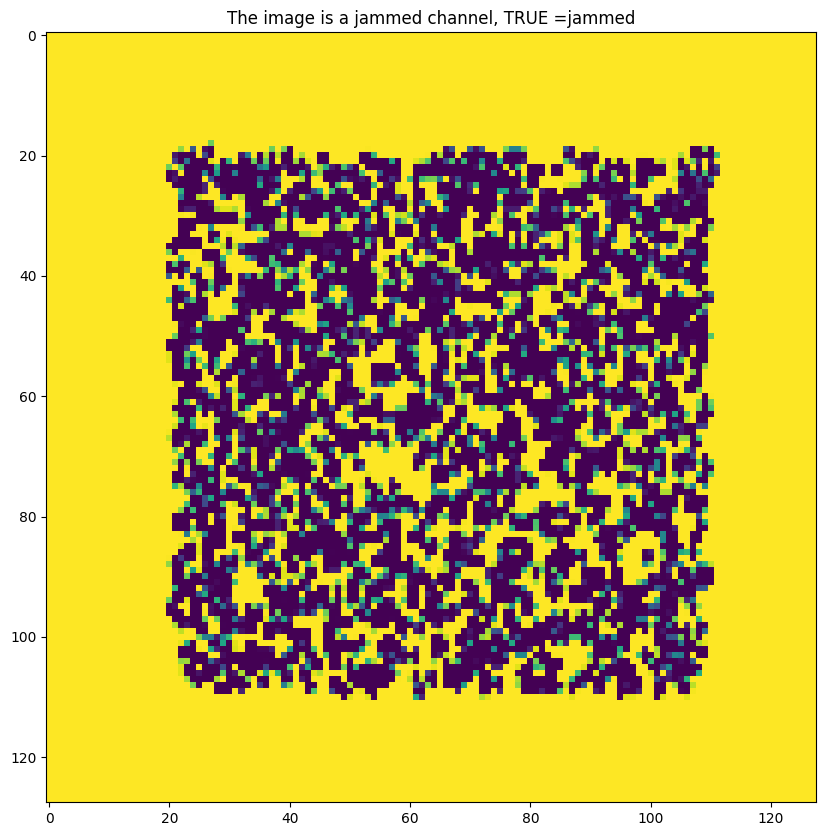

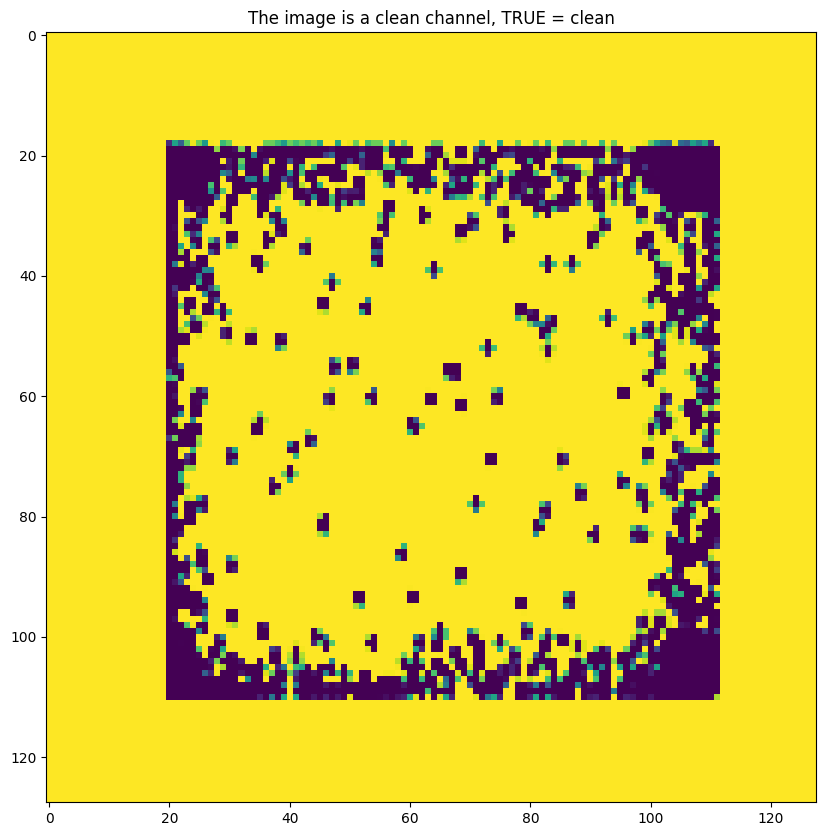

In [22]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [23]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [25]:
values_th=np.arange(normal_values[0],jammed_values[0],0.0005)
print(len(values_th))

57


In [26]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0357


  0%|          | 2/800 [00:00<00:54, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0625


  0%|          | 4/800 [00:00<00:53, 14.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0330


  1%|          | 6/800 [00:00<00:53, 14.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0624


  1%|          | 8/800 [00:00<00:52, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0624


  1%|▏         | 10/800 [00:00<00:54, 14.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0618


  2%|▏         | 12/800 [00:00<00:54, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0353


  2%|▏         | 14/800 [00:00<00:54, 14.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0330


  2%|▏         | 16/800 [00:01<00:54, 14.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0328


  2%|▏         | 18/800 [00:01<00:53, 14.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0322


  2%|▎         | 20/800 [00:01<00:52, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0627


  3%|▎         | 22/800 [00:01<00:53, 14.60it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0329


  3%|▎         | 24/800 [00:01<00:54, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


  3%|▎         | 26/800 [00:01<00:56, 13.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0620


  4%|▎         | 28/800 [00:01<00:56, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0616


  4%|▍         | 30/800 [00:02<00:56, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0350


  4%|▍         | 32/800 [00:02<00:57, 13.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0620


  4%|▍         | 34/800 [00:02<00:55, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


  4%|▍         | 36/800 [00:02<00:56, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


  5%|▍         | 38/800 [00:02<00:55, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0627


  5%|▌         | 40/800 [00:02<00:54, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


  5%|▌         | 42/800 [00:02<00:54, 13.97it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0627


  6%|▌         | 44/800 [00:03<00:56, 13.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0382


  6%|▌         | 46/800 [00:03<00:55, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0379


  6%|▌         | 48/800 [00:03<00:54, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0372


  6%|▋         | 50/800 [00:03<00:53, 14.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


  6%|▋         | 52/800 [00:03<00:53, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0612


  7%|▋         | 54/800 [00:03<00:55, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


  7%|▋         | 56/800 [00:04<00:55, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


  7%|▋         | 58/800 [00:04<00:56, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0636


  8%|▊         | 60/800 [00:04<00:54, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0349


  8%|▊         | 62/800 [00:04<00:55, 13.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


  8%|▊         | 64/800 [00:04<00:53, 13.64it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0622


  8%|▊         | 66/800 [00:04<00:53, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0357


  8%|▊         | 68/800 [00:04<00:52, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0630


  9%|▉         | 70/800 [00:05<00:51, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0320


  9%|▉         | 72/800 [00:05<00:52, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


  9%|▉         | 74/800 [00:05<00:50, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 10%|▉         | 76/800 [00:05<00:50, 14.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0318


 10%|▉         | 78/800 [00:05<00:49, 14.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0348


 10%|█         | 80/800 [00:05<00:50, 14.39it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0359


 10%|█         | 82/800 [00:05<00:53, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0621


 10%|█         | 84/800 [00:06<00:53, 13.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0337


 11%|█         | 86/800 [00:06<00:52, 13.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0616


 11%|█         | 88/800 [00:06<00:50, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0383


 11%|█▏        | 90/800 [00:06<00:49, 14.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0347


 12%|█▏        | 92/800 [00:06<00:51, 13.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0621


 12%|█▏        | 94/800 [00:06<00:51, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0314


 12%|█▏        | 96/800 [00:06<00:50, 13.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0329


 12%|█▏        | 98/800 [00:07<00:51, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0618


 12%|█▎        | 100/800 [00:07<00:49, 14.05it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0627


 13%|█▎        | 102/800 [00:07<00:51, 13.48it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0324


 13%|█▎        | 104/800 [00:07<00:57, 12.17it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0288


 13%|█▎        | 106/800 [00:07<00:59, 11.62it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0625


 14%|█▎        | 108/800 [00:07<01:02, 11.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0300


 14%|█▍        | 110/800 [00:08<01:02, 11.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0620


 14%|█▍        | 112/800 [00:08<01:01, 11.11it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0623


 14%|█▍        | 114/800 [00:08<01:02, 11.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0625


 14%|█▍        | 116/800 [00:08<01:02, 10.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0617


 15%|█▍        | 118/800 [00:08<01:03, 10.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0628


 15%|█▌        | 120/800 [00:09<01:03, 10.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0620


 15%|█▌        | 122/800 [00:09<01:06, 10.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0628


 16%|█▌        | 124/800 [00:09<01:04, 10.47it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0625


 16%|█▌        | 126/800 [00:09<01:04, 10.45it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0376


 16%|█▌        | 128/800 [00:09<01:03, 10.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0308


 16%|█▋        | 130/800 [00:09<01:01, 10.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 16%|█▋        | 132/800 [00:10<00:57, 11.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 17%|█▋        | 134/800 [00:10<00:55, 11.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 17%|█▋        | 136/800 [00:10<00:54, 12.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0358


 17%|█▋        | 138/800 [00:10<00:53, 12.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


 18%|█▊        | 140/800 [00:10<00:52, 12.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 18%|█▊        | 142/800 [00:10<00:50, 12.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0331


 18%|█▊        | 144/800 [00:11<00:49, 13.20it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0352


 18%|█▊        | 146/800 [00:11<00:48, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0618


 18%|█▊        | 148/800 [00:11<00:47, 13.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 19%|█▉        | 150/800 [00:11<00:48, 13.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0622


 19%|█▉        | 152/800 [00:11<00:48, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0335


 19%|█▉        | 154/800 [00:11<00:48, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0348


 20%|█▉        | 156/800 [00:11<00:48, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 20%|█▉        | 158/800 [00:12<00:46, 13.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0622


 20%|██        | 160/800 [00:12<00:47, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0618


 20%|██        | 162/800 [00:12<00:47, 13.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0636


 20%|██        | 164/800 [00:12<00:48, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0333


 21%|██        | 166/800 [00:12<00:47, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0327


 21%|██        | 168/800 [00:12<00:48, 13.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0313


 21%|██▏       | 170/800 [00:12<00:48, 13.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 22%|██▏       | 172/800 [00:13<00:48, 13.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0358


 22%|██▏       | 174/800 [00:13<00:47, 13.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0349


 22%|██▏       | 176/800 [00:13<00:47, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 22%|██▏       | 178/800 [00:13<00:47, 13.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 22%|██▎       | 180/800 [00:13<00:47, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0617


 23%|██▎       | 182/800 [00:13<00:47, 12.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 23%|██▎       | 184/800 [00:14<00:47, 12.95it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0623


 23%|██▎       | 186/800 [00:14<00:47, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0621


 24%|██▎       | 188/800 [00:14<00:46, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0361


 24%|██▍       | 190/800 [00:14<00:45, 13.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0357


 24%|██▍       | 192/800 [00:14<00:43, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0620


 24%|██▍       | 194/800 [00:14<00:44, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0352


 24%|██▍       | 196/800 [00:14<00:43, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 25%|██▍       | 198/800 [00:15<00:41, 14.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0368


 25%|██▌       | 200/800 [00:15<00:41, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 25%|██▌       | 202/800 [00:15<00:41, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0362


 26%|██▌       | 204/800 [00:15<00:41, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0326


 26%|██▌       | 206/800 [00:15<00:40, 14.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0303


 26%|██▌       | 208/800 [00:15<00:40, 14.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0620


 26%|██▋       | 210/800 [00:15<00:41, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0382


 26%|██▋       | 212/800 [00:16<00:41, 14.10it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0628


 27%|██▋       | 214/800 [00:16<00:44, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0622


 27%|██▋       | 216/800 [00:16<00:43, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0621


 27%|██▋       | 218/800 [00:16<00:42, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0634


 28%|██▊       | 220/800 [00:16<00:43, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 28%|██▊       | 222/800 [00:16<00:42, 13.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0344


 28%|██▊       | 224/800 [00:16<00:41, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0655


 28%|██▊       | 226/800 [00:17<00:41, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 28%|██▊       | 228/800 [00:17<00:41, 13.89it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0365


 29%|██▉       | 230/800 [00:17<00:42, 13.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0317


 29%|██▉       | 232/800 [00:17<00:42, 13.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0633


 29%|██▉       | 234/800 [00:17<00:42, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0351


 30%|██▉       | 236/800 [00:17<00:42, 13.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0354


 30%|██▉       | 238/800 [00:17<00:43, 12.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 30%|███       | 240/800 [00:18<00:43, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0354


 30%|███       | 242/800 [00:18<00:44, 12.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0627


 30%|███       | 244/800 [00:18<00:42, 12.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 31%|███       | 246/800 [00:18<00:42, 13.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0363


 31%|███       | 248/800 [00:18<00:41, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0618


 31%|███▏      | 250/800 [00:18<00:39, 13.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0318


 32%|███▏      | 252/800 [00:19<00:38, 14.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0369


 32%|███▏      | 254/800 [00:19<00:38, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0357


 32%|███▏      | 256/800 [00:19<00:36, 14.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 32%|███▏      | 258/800 [00:19<00:37, 14.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 32%|███▎      | 260/800 [00:19<00:38, 14.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0348


 33%|███▎      | 262/800 [00:19<00:39, 13.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0635


 33%|███▎      | 264/800 [00:19<00:40, 13.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0631


 33%|███▎      | 266/800 [00:20<00:45, 11.82it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0632


 34%|███▎      | 268/800 [00:20<00:47, 11.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0615


 34%|███▍      | 270/800 [00:20<00:49, 10.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0354


 34%|███▍      | 272/800 [00:20<00:49, 10.60it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0629


 34%|███▍      | 274/800 [00:20<00:49, 10.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0630


 34%|███▍      | 276/800 [00:21<00:50, 10.47it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0269


 35%|███▍      | 278/800 [00:21<00:50, 10.42it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0286


 35%|███▌      | 280/800 [00:21<00:51, 10.08it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0363


 35%|███▌      | 282/800 [00:21<00:51, 10.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0323


 36%|███▌      | 284/800 [00:21<00:49, 10.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0615


 36%|███▌      | 286/800 [00:22<00:48, 10.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0627


 36%|███▌      | 288/800 [00:22<00:48, 10.47it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0625


 36%|███▋      | 290/800 [00:22<00:48, 10.53it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0370


 36%|███▋      | 292/800 [00:22<00:48, 10.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0600


 37%|███▋      | 294/800 [00:22<00:47, 10.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0334


 37%|███▋      | 296/800 [00:22<00:43, 11.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0362


 37%|███▋      | 298/800 [00:23<00:41, 12.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 38%|███▊      | 300/800 [00:23<00:38, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0357


 38%|███▊      | 302/800 [00:23<00:37, 13.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0630


 38%|███▊      | 304/800 [00:23<00:37, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 38%|███▊      | 306/800 [00:23<00:37, 13.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0627


 38%|███▊      | 308/800 [00:23<00:37, 13.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0621


 39%|███▉      | 310/800 [00:23<00:36, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0624


 39%|███▉      | 312/800 [00:24<00:36, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0624


 39%|███▉      | 314/800 [00:24<00:36, 13.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0359


 40%|███▉      | 316/800 [00:24<00:36, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0364


 40%|███▉      | 318/800 [00:24<00:36, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


 40%|████      | 320/800 [00:24<00:35, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0359


 40%|████      | 322/800 [00:24<00:34, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0619


 40%|████      | 324/800 [00:24<00:33, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 41%|████      | 326/800 [00:25<00:32, 14.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0614


 41%|████      | 328/800 [00:25<00:32, 14.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0634


 41%|████▏     | 330/800 [00:25<00:33, 14.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0625


 42%|████▏     | 332/800 [00:25<00:33, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 42%|████▏     | 334/800 [00:25<00:33, 13.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0367


 42%|████▏     | 336/800 [00:25<00:34, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0638


 42%|████▏     | 338/800 [00:25<00:33, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0348


 42%|████▎     | 340/800 [00:26<00:33, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0353


 43%|████▎     | 342/800 [00:26<00:32, 13.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0625


 43%|████▎     | 344/800 [00:26<00:31, 14.34it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0631


 43%|████▎     | 346/800 [00:26<00:33, 13.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0347


 44%|████▎     | 348/800 [00:26<00:32, 13.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0331


 44%|████▍     | 350/800 [00:26<00:32, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0631


 44%|████▍     | 352/800 [00:26<00:31, 14.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0334


 44%|████▍     | 354/800 [00:27<00:31, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0312


 44%|████▍     | 356/800 [00:27<00:31, 14.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0316


 45%|████▍     | 358/800 [00:27<00:31, 14.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 45%|████▌     | 360/800 [00:27<00:30, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0638


 45%|████▌     | 362/800 [00:27<00:31, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0652


 46%|████▌     | 364/800 [00:27<00:30, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0355


 46%|████▌     | 366/800 [00:27<00:30, 14.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0367


 46%|████▌     | 368/800 [00:28<00:30, 14.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0355


 46%|████▋     | 370/800 [00:28<00:31, 13.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0315


 46%|████▋     | 372/800 [00:28<00:30, 13.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0619


 47%|████▋     | 374/800 [00:28<00:30, 14.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0626


 47%|████▋     | 376/800 [00:28<00:31, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0356


 47%|████▋     | 378/800 [00:28<00:31, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0353


 48%|████▊     | 380/800 [00:29<00:31, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 48%|████▊     | 382/800 [00:29<00:30, 13.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0634


 48%|████▊     | 384/800 [00:29<00:29, 14.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0632


 48%|████▊     | 386/800 [00:29<00:29, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 48%|████▊     | 388/800 [00:29<00:29, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0324


 49%|████▉     | 390/800 [00:29<00:29, 14.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0617


 49%|████▉     | 392/800 [00:29<00:28, 14.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 49%|████▉     | 394/800 [00:29<00:28, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0332


 50%|████▉     | 396/800 [00:30<00:29, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0626


 50%|████▉     | 398/800 [00:30<00:28, 13.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0613


 50%|█████     | 400/800 [00:30<00:28, 14.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 50%|█████     | 402/800 [00:30<00:28, 14.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0619


 50%|█████     | 404/800 [00:30<00:28, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0355


 51%|█████     | 406/800 [00:30<00:27, 14.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0339


 51%|█████     | 408/800 [00:30<00:27, 14.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0329


 51%|█████▏    | 410/800 [00:31<00:27, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0624


 52%|█████▏    | 412/800 [00:31<00:27, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0612


 52%|█████▏    | 414/800 [00:31<00:27, 14.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0366


 52%|█████▏    | 416/800 [00:31<00:27, 14.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0332


 52%|█████▏    | 418/800 [00:31<00:27, 14.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0636


 52%|█████▎    | 420/800 [00:31<00:28, 13.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0624


 53%|█████▎    | 422/800 [00:32<00:28, 13.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0333


 53%|█████▎    | 424/800 [00:32<00:28, 13.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0326


 53%|█████▎    | 426/800 [00:32<00:27, 13.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0364


 54%|█████▎    | 428/800 [00:32<00:27, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0354


 54%|█████▍    | 430/800 [00:32<00:27, 13.53it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0633


 54%|█████▍    | 432/800 [00:32<00:28, 12.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0620


 54%|█████▍    | 434/800 [00:32<00:30, 11.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0359


 55%|█████▍    | 436/800 [00:33<00:32, 11.34it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0625


 55%|█████▍    | 438/800 [00:33<00:33, 10.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0347


 55%|█████▌    | 440/800 [00:33<00:33, 10.59it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0630


 55%|█████▌    | 442/800 [00:33<00:35, 10.16it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0617


 56%|█████▌    | 444/800 [00:34<00:36,  9.89it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0360


 56%|█████▌    | 446/800 [00:34<00:36,  9.80it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0623


 56%|█████▌    | 447/800 [00:34<00:36,  9.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0624


 56%|█████▌    | 449/800 [00:34<00:35, 10.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0324


 56%|█████▋    | 451/800 [00:34<00:33, 10.39it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0621


 57%|█████▋    | 453/800 [00:34<00:33, 10.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0333


 57%|█████▋    | 455/800 [00:35<00:33, 10.43it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0339


 57%|█████▋    | 457/800 [00:35<00:33, 10.38it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0371


 57%|█████▋    | 459/800 [00:35<00:33, 10.23it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0613


 58%|█████▊    | 461/800 [00:35<00:33, 10.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0313


 58%|█████▊    | 463/800 [00:35<00:32, 10.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0622


 58%|█████▊    | 465/800 [00:35<00:29, 11.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 58%|█████▊    | 467/800 [00:36<00:27, 11.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0301


 59%|█████▊    | 469/800 [00:36<00:26, 12.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 59%|█████▉    | 471/800 [00:36<00:26, 12.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 59%|█████▉    | 473/800 [00:36<00:26, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 59%|█████▉    | 475/800 [00:36<00:25, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0367


 60%|█████▉    | 477/800 [00:36<00:25, 12.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0351


 60%|█████▉    | 479/800 [00:37<00:24, 13.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0646


 60%|██████    | 481/800 [00:37<00:24, 12.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


 60%|██████    | 483/800 [00:37<00:24, 13.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0296


 61%|██████    | 485/800 [00:37<00:23, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0321


 61%|██████    | 487/800 [00:37<00:23, 13.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0345


 61%|██████    | 489/800 [00:37<00:24, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0356


 61%|██████▏   | 491/800 [00:37<00:24, 12.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0350


 62%|██████▏   | 493/800 [00:38<00:23, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0631


 62%|██████▏   | 495/800 [00:38<00:22, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0319


 62%|██████▏   | 497/800 [00:38<00:22, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0354


 62%|██████▏   | 499/800 [00:38<00:21, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0356


 63%|██████▎   | 501/800 [00:38<00:21, 14.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 63%|██████▎   | 503/800 [00:38<00:21, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0364


 63%|██████▎   | 505/800 [00:38<00:21, 13.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0378


 63%|██████▎   | 507/800 [00:39<00:36,  8.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0619


 64%|██████▎   | 509/800 [00:39<00:32,  8.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0620


 64%|██████▍   | 511/800 [00:39<00:29,  9.77it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0354


 64%|██████▍   | 513/800 [00:39<00:27, 10.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 64%|██████▍   | 515/800 [00:40<00:26, 10.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0318


 65%|██████▍   | 517/800 [00:40<00:25, 11.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0345


 65%|██████▍   | 519/800 [00:40<00:24, 11.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0645


 65%|██████▌   | 521/800 [00:40<00:23, 11.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0331


 65%|██████▌   | 523/800 [00:40<00:23, 11.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0317


 66%|██████▌   | 525/800 [00:40<00:23, 11.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0625


 66%|██████▌   | 527/800 [00:41<00:23, 11.66it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0359


 66%|██████▌   | 529/800 [00:41<00:23, 11.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0626


 66%|██████▋   | 531/800 [00:41<00:23, 11.47it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0628


 67%|██████▋   | 533/800 [00:41<00:23, 11.30it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0627


 67%|██████▋   | 535/800 [00:41<00:23, 11.41it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0612


 67%|██████▋   | 537/800 [00:42<00:23, 11.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 67%|██████▋   | 539/800 [00:42<00:22, 11.39it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0607


 68%|██████▊   | 541/800 [00:42<00:22, 11.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0617


 68%|██████▊   | 543/800 [00:42<00:22, 11.47it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0319


 68%|██████▊   | 545/800 [00:42<00:21, 11.74it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 68%|██████▊   | 547/800 [00:42<00:21, 11.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0281


 69%|██████▊   | 549/800 [00:43<00:21, 11.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0316


 69%|██████▉   | 551/800 [00:43<00:20, 12.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0621


 69%|██████▉   | 553/800 [00:43<00:19, 12.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0622


 69%|██████▉   | 555/800 [00:43<00:19, 12.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0609


 70%|██████▉   | 557/800 [00:43<00:19, 12.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0611


 70%|██████▉   | 559/800 [00:43<00:19, 12.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0337


 70%|███████   | 561/800 [00:44<00:20, 11.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0322


 70%|███████   | 563/800 [00:44<00:20, 11.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0624


 71%|███████   | 565/800 [00:44<00:19, 11.89it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0613


 71%|███████   | 567/800 [00:44<00:19, 11.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0619


 71%|███████   | 569/800 [00:44<00:19, 11.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0626


 71%|███████▏  | 571/800 [00:44<00:18, 12.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0622


 72%|███████▏  | 573/800 [00:45<00:19, 11.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0318


 72%|███████▏  | 575/800 [00:45<00:18, 12.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0318


 72%|███████▏  | 577/800 [00:45<00:17, 12.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0312


 72%|███████▏  | 579/800 [00:45<00:17, 12.40it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0625


 73%|███████▎  | 581/800 [00:45<00:17, 12.27it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0632


 73%|███████▎  | 583/800 [00:45<00:18, 11.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0359


 73%|███████▎  | 585/800 [00:46<00:19, 11.10it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0356


 73%|███████▎  | 587/800 [00:46<00:20, 10.61it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0349


 74%|███████▎  | 589/800 [00:46<00:20, 10.50it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0621


 74%|███████▍  | 591/800 [00:46<00:19, 10.50it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0629


 74%|███████▍  | 593/800 [00:46<00:20, 10.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0329


 74%|███████▍  | 595/800 [00:47<00:20, 10.17it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0621


 75%|███████▍  | 597/800 [00:47<00:20, 10.01it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0626


 75%|███████▍  | 599/800 [00:47<00:20,  9.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0618


 75%|███████▌  | 600/800 [00:47<00:20,  9.54it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0619


 75%|███████▌  | 601/800 [00:47<00:20,  9.60it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0354


 75%|███████▌  | 602/800 [00:47<00:20,  9.51it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0317


 75%|███████▌  | 603/800 [00:47<00:20,  9.58it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0622


 76%|███████▌  | 604/800 [00:48<00:20,  9.48it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0321


 76%|███████▌  | 605/800 [00:48<00:20,  9.38it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0630


 76%|███████▌  | 606/800 [00:48<00:20,  9.30it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0632


 76%|███████▌  | 607/800 [00:48<00:20,  9.26it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0631


 76%|███████▌  | 609/800 [00:48<00:19,  9.79it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0333


 76%|███████▋  | 610/800 [00:48<00:19,  9.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0626


 76%|███████▋  | 612/800 [00:48<00:17, 10.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0633


 77%|███████▋  | 614/800 [00:48<00:16, 11.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0622


 77%|███████▋  | 616/800 [00:49<00:15, 11.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0336


 77%|███████▋  | 618/800 [00:49<00:16, 11.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0632


 78%|███████▊  | 620/800 [00:49<00:15, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0620


 78%|███████▊  | 622/800 [00:49<00:14, 12.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0318


 78%|███████▊  | 624/800 [00:49<00:14, 12.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0628


 78%|███████▊  | 626/800 [00:49<00:14, 12.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0615


 78%|███████▊  | 628/800 [00:50<00:13, 12.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0332


 79%|███████▉  | 630/800 [00:50<00:13, 12.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0313


 79%|███████▉  | 632/800 [00:50<00:13, 12.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0615


 79%|███████▉  | 634/800 [00:50<00:12, 12.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0619


 80%|███████▉  | 636/800 [00:50<00:12, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0625


 80%|███████▉  | 638/800 [00:50<00:12, 12.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 80%|████████  | 640/800 [00:51<00:12, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0614


 80%|████████  | 642/800 [00:51<00:12, 13.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0315


 80%|████████  | 644/800 [00:51<00:11, 13.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0620


 81%|████████  | 646/800 [00:51<00:11, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0633


 81%|████████  | 648/800 [00:51<00:11, 12.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0313


 81%|████████▏ | 650/800 [00:51<00:11, 12.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0317


 82%|████████▏ | 652/800 [00:51<00:11, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0378


 82%|████████▏ | 654/800 [00:52<00:11, 12.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0619


 82%|████████▏ | 656/800 [00:52<00:10, 13.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 82%|████████▏ | 658/800 [00:52<00:11, 12.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0617


 82%|████████▎ | 660/800 [00:52<00:10, 13.00it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0628


 83%|████████▎ | 662/800 [00:52<00:10, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0630


 83%|████████▎ | 664/800 [00:52<00:10, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0617


 83%|████████▎ | 666/800 [00:52<00:10, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0633


 84%|████████▎ | 668/800 [00:53<00:09, 13.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


 84%|████████▍ | 670/800 [00:53<00:09, 13.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 84%|████████▍ | 672/800 [00:53<00:09, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0625


 84%|████████▍ | 674/800 [00:53<00:09, 13.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0319


 84%|████████▍ | 676/800 [00:53<00:09, 13.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0341


 85%|████████▍ | 678/800 [00:53<00:09, 13.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0357


 85%|████████▌ | 680/800 [00:54<00:09, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0625


 85%|████████▌ | 682/800 [00:54<00:09, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0632


 86%|████████▌ | 684/800 [00:54<00:09, 12.78it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0615


 86%|████████▌ | 686/800 [00:54<00:08, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0368


 86%|████████▌ | 688/800 [00:54<00:08, 13.23it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0269


 86%|████████▋ | 690/800 [00:54<00:08, 12.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 86%|████████▋ | 692/800 [00:54<00:08, 13.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0379


 87%|████████▋ | 694/800 [00:55<00:07, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0330


 87%|████████▋ | 696/800 [00:55<00:07, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0311


 87%|████████▋ | 698/800 [00:55<00:07, 13.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 88%|████████▊ | 700/800 [00:55<00:07, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0621


 88%|████████▊ | 702/800 [00:55<00:07, 13.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0629


 88%|████████▊ | 704/800 [00:55<00:07, 13.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0383


 88%|████████▊ | 706/800 [00:56<00:06, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0334


 88%|████████▊ | 708/800 [00:56<00:06, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0622


 89%|████████▉ | 710/800 [00:56<00:06, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0628


 89%|████████▉ | 712/800 [00:56<00:06, 13.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0618


 89%|████████▉ | 714/800 [00:56<00:06, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0347


 90%|████████▉ | 716/800 [00:56<00:06, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0324


 90%|████████▉ | 718/800 [00:56<00:05, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 90%|█████████ | 720/800 [00:57<00:05, 14.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0633


 90%|█████████ | 722/800 [00:57<00:06, 12.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 90%|█████████ | 724/800 [00:57<00:05, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0306


 91%|█████████ | 726/800 [00:57<00:05, 13.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0316


 91%|█████████ | 728/800 [00:57<00:05, 13.44it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0318


 91%|█████████▏| 730/800 [00:57<00:05, 13.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0351


 92%|█████████▏| 732/800 [00:57<00:05, 13.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0363


 92%|█████████▏| 734/800 [00:58<00:04, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 92%|█████████▏| 736/800 [00:58<00:04, 13.47it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0295


 92%|█████████▏| 738/800 [00:58<00:04, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0627


 92%|█████████▎| 740/800 [00:58<00:04, 13.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0624


 93%|█████████▎| 742/800 [00:58<00:04, 13.67it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0333


 93%|█████████▎| 744/800 [00:58<00:04, 12.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0611


 93%|█████████▎| 746/800 [00:59<00:04, 11.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 94%|█████████▎| 748/800 [00:59<00:04, 11.14it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0378


 94%|█████████▍| 750/800 [00:59<00:04, 10.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0626


 94%|█████████▍| 752/800 [00:59<00:04, 10.56it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0623


 94%|█████████▍| 754/800 [00:59<00:04, 10.58it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0622


 94%|█████████▍| 756/800 [01:00<00:04, 10.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0332


 95%|█████████▍| 758/800 [01:00<00:04, 10.20it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0318


 95%|█████████▌| 760/800 [01:00<00:03, 10.30it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0365


 95%|█████████▌| 762/800 [01:00<00:03, 10.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0292


 96%|█████████▌| 764/800 [01:00<00:03, 10.33it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0627


 96%|█████████▌| 766/800 [01:01<00:03,  9.93it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0297


 96%|█████████▌| 767/800 [01:01<00:03,  9.55it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0630


 96%|█████████▌| 768/800 [01:01<00:03,  9.42it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0327


 96%|█████████▌| 769/800 [01:01<00:03,  9.53it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0628


 96%|█████████▋| 770/800 [01:01<00:03,  9.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0321


 96%|█████████▋| 771/800 [01:01<00:03,  9.55it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0658


 96%|█████████▋| 772/800 [01:01<00:02,  9.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0338


 97%|█████████▋| 774/800 [01:01<00:02, 10.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 97%|█████████▋| 776/800 [01:02<00:02, 11.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0322


 97%|█████████▋| 778/800 [01:02<00:01, 11.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0629


 98%|█████████▊| 780/800 [01:02<00:01, 12.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0621


 98%|█████████▊| 782/800 [01:02<00:01, 12.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0352


 98%|█████████▊| 784/800 [01:02<00:01, 12.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0321


 98%|█████████▊| 786/800 [01:02<00:01, 12.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 98%|█████████▊| 788/800 [01:02<00:00, 12.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0352


 99%|█████████▉| 790/800 [01:03<00:00, 12.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0332


 99%|█████████▉| 792/800 [01:03<00:00, 12.91it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0305


 99%|█████████▉| 794/800 [01:03<00:00, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0323


100%|█████████▉| 796/800 [01:03<00:00, 12.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


100%|█████████▉| 798/800 [01:03<00:00, 12.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


100%|██████████| 800/800 [01:03<00:00, 12.51it/s]

800


In [27]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [28]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [29]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00375, 0.02875, 0.09875]
[0.22625, 0.21125, 0.185, 0.14625, 0.09875, 0.07125, 0.04375, 0.035, 0.02375, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.0125, 0.0125, 0.01125, 0.01125]


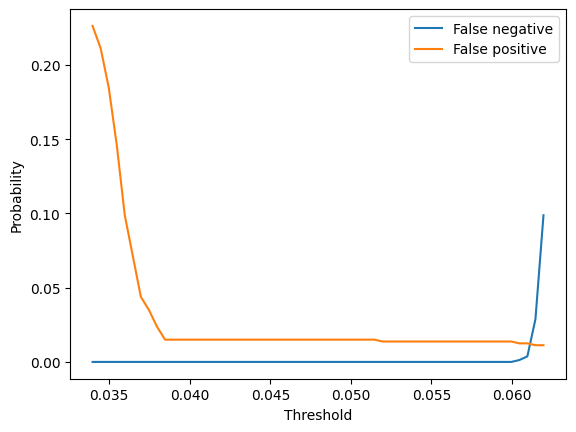

In [30]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [31]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0259


  0%|          | 1/800 [00:00<01:30,  8.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0357


  0%|          | 2/800 [00:00<01:24,  9.45it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0625


  0%|          | 4/800 [00:00<01:19, 10.07it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0330


  1%|          | 6/800 [00:00<01:17, 10.28it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0624


  1%|          | 8/800 [00:00<01:17, 10.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0624


  1%|▏         | 10/800 [00:00<01:16, 10.39it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0618


  2%|▏         | 12/800 [00:01<01:16, 10.28it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0353


  2%|▏         | 14/800 [00:01<01:15, 10.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0330


  2%|▏         | 16/800 [00:01<01:08, 11.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0328


  2%|▏         | 18/800 [00:01<01:03, 12.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0322


  2%|▎         | 20/800 [00:01<01:00, 12.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0627


  3%|▎         | 22/800 [00:01<00:58, 13.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0329


  3%|▎         | 24/800 [00:02<00:55, 13.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0356


  3%|▎         | 26/800 [00:02<00:55, 13.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0620


  4%|▎         | 28/800 [00:02<00:54, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0616


  4%|▍         | 30/800 [00:02<00:53, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0350


  4%|▍         | 32/800 [00:02<00:52, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0620


  4%|▍         | 34/800 [00:02<00:51, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0626


  4%|▍         | 36/800 [00:02<00:51, 14.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0299


  5%|▍         | 38/800 [00:02<00:50, 15.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0627


  5%|▌         | 40/800 [00:03<00:51, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0636


  5%|▌         | 42/800 [00:03<00:53, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0627


  6%|▌         | 44/800 [00:03<00:51, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0382


  6%|▌         | 46/800 [00:03<00:50, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0379


  6%|▌         | 48/800 [00:03<00:51, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0372


  6%|▋         | 50/800 [00:03<00:53, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0624


  6%|▋         | 52/800 [00:03<00:52, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0612


  7%|▋         | 54/800 [00:04<00:52, 14.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0356


  7%|▋         | 56/800 [00:04<00:51, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


  7%|▋         | 58/800 [00:04<00:49, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0636


  8%|▊         | 60/800 [00:04<00:49, 14.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0349


  8%|▊         | 62/800 [00:04<00:49, 15.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0632


  8%|▊         | 64/800 [00:04<00:50, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


  8%|▊         | 66/800 [00:04<00:50, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0357


  8%|▊         | 68/800 [00:05<00:50, 14.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0630


  9%|▉         | 70/800 [00:05<00:48, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


  9%|▉         | 72/800 [00:05<00:49, 14.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0625


  9%|▉         | 74/800 [00:05<00:49, 14.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 10%|▉         | 76/800 [00:05<00:50, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0318


 10%|▉         | 78/800 [00:05<00:50, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0348


 10%|█         | 80/800 [00:05<00:48, 14.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0359


 10%|█         | 82/800 [00:06<00:49, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0621


 10%|█         | 84/800 [00:06<00:49, 14.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0337


 11%|█         | 86/800 [00:06<00:48, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0616


 11%|█         | 88/800 [00:06<00:50, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0383


 11%|█▏        | 90/800 [00:06<00:49, 14.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0347


 12%|█▏        | 92/800 [00:06<00:49, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0621


 12%|█▏        | 94/800 [00:06<00:49, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0314


 12%|█▏        | 96/800 [00:06<00:47, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0329


 12%|█▏        | 98/800 [00:07<00:48, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0618


 12%|█▎        | 100/800 [00:07<00:47, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0627


 13%|█▎        | 102/800 [00:07<00:47, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0324


 13%|█▎        | 104/800 [00:07<00:47, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 13%|█▎        | 106/800 [00:07<00:48, 14.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0625


 14%|█▎        | 108/800 [00:07<00:47, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 14%|█▍        | 110/800 [00:07<00:47, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0620


 14%|█▍        | 112/800 [00:08<00:46, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0623


 14%|█▍        | 114/800 [00:08<00:46, 14.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 14%|█▍        | 116/800 [00:08<00:46, 14.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0617


 15%|█▍        | 118/800 [00:08<00:48, 14.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 15%|█▌        | 120/800 [00:08<00:48, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0620


 15%|█▌        | 122/800 [00:08<00:48, 14.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0628


 16%|█▌        | 124/800 [00:08<00:48, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0625


 16%|█▌        | 126/800 [00:09<00:47, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0376


 16%|█▌        | 128/800 [00:09<00:47, 14.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0308


 16%|█▋        | 130/800 [00:09<00:47, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0623


 16%|█▋        | 132/800 [00:09<00:47, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 17%|█▋        | 134/800 [00:09<00:48, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 17%|█▋        | 136/800 [00:09<00:51, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0358


 17%|█▋        | 138/800 [00:09<00:49, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 18%|█▊        | 140/800 [00:10<00:47, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


 18%|█▊        | 142/800 [00:10<00:46, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0331


 18%|█▊        | 144/800 [00:10<00:48, 13.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0352


 18%|█▊        | 146/800 [00:10<00:46, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0618


 18%|█▊        | 148/800 [00:10<00:45, 14.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 19%|█▉        | 150/800 [00:10<00:45, 14.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 19%|█▉        | 152/800 [00:10<00:46, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0335


 19%|█▉        | 154/800 [00:11<00:46, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0348


 20%|█▉        | 156/800 [00:11<00:46, 13.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0628


 20%|█▉        | 158/800 [00:11<00:47, 13.43it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0622


 20%|██        | 160/800 [00:11<00:52, 12.14it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0618


 20%|██        | 162/800 [00:11<00:56, 11.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0636


 20%|██        | 164/800 [00:12<00:57, 10.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0333


 21%|██        | 166/800 [00:12<00:58, 10.88it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0327


 21%|██        | 168/800 [00:12<00:57, 10.93it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0313


 21%|██▏       | 170/800 [00:12<00:58, 10.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0625


 22%|██▏       | 172/800 [00:12<00:58, 10.83it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0358


 22%|██▏       | 174/800 [00:12<00:57, 10.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0349


 22%|██▏       | 176/800 [00:13<00:58, 10.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0625


 22%|██▏       | 178/800 [00:13<00:58, 10.67it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0279


 22%|██▎       | 180/800 [00:13<00:59, 10.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0617


 23%|██▎       | 182/800 [00:13<00:59, 10.41it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0294


 23%|██▎       | 184/800 [00:13<00:58, 10.47it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0623


 23%|██▎       | 186/800 [00:14<01:00, 10.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0621


 24%|██▎       | 188/800 [00:14<00:55, 11.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0361


 24%|██▍       | 190/800 [00:14<00:50, 12.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0357


 24%|██▍       | 192/800 [00:14<00:47, 12.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0620


 24%|██▍       | 194/800 [00:14<00:45, 13.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0352


 24%|██▍       | 196/800 [00:14<00:44, 13.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 25%|██▍       | 198/800 [00:14<00:43, 13.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0368


 25%|██▌       | 200/800 [00:15<00:43, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 25%|██▌       | 202/800 [00:15<00:43, 13.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0362


 26%|██▌       | 204/800 [00:15<00:43, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0326


 26%|██▌       | 206/800 [00:15<00:42, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0303


 26%|██▌       | 208/800 [00:15<00:42, 13.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0620


 26%|██▋       | 210/800 [00:15<00:41, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0382


 26%|██▋       | 212/800 [00:15<00:40, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 27%|██▋       | 214/800 [00:16<00:40, 14.52it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0622


 27%|██▋       | 216/800 [00:16<00:41, 14.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0621


 27%|██▋       | 218/800 [00:16<00:40, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 28%|██▊       | 220/800 [00:16<00:42, 13.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0623


 28%|██▊       | 222/800 [00:16<00:42, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0344


 28%|██▊       | 224/800 [00:16<00:42, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0655


 28%|██▊       | 226/800 [00:16<00:41, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


 28%|██▊       | 228/800 [00:17<00:40, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0365


 29%|██▉       | 230/800 [00:17<00:40, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0317


 29%|██▉       | 232/800 [00:17<00:40, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 29%|██▉       | 234/800 [00:17<00:39, 14.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0351


 30%|██▉       | 236/800 [00:17<00:39, 14.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0354


 30%|██▉       | 238/800 [00:17<00:39, 14.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0624


 30%|███       | 240/800 [00:17<00:39, 14.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0354


 30%|███       | 242/800 [00:18<00:40, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0627


 30%|███       | 244/800 [00:18<00:39, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 31%|███       | 246/800 [00:18<00:40, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0363


 31%|███       | 248/800 [00:18<00:38, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0618


 31%|███▏      | 250/800 [00:18<00:39, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0318


 32%|███▏      | 252/800 [00:18<00:38, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0369


 32%|███▏      | 254/800 [00:18<00:38, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0357


 32%|███▏      | 256/800 [00:19<00:38, 14.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 32%|███▏      | 258/800 [00:19<00:37, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 32%|███▎      | 260/800 [00:19<00:37, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0348


 33%|███▎      | 262/800 [00:19<00:37, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0635


 33%|███▎      | 264/800 [00:19<00:38, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0631


 33%|███▎      | 266/800 [00:19<00:37, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0632


 34%|███▎      | 268/800 [00:19<00:37, 14.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0615


 34%|███▍      | 270/800 [00:20<00:36, 14.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0354


 34%|███▍      | 272/800 [00:20<00:37, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0629


 34%|███▍      | 274/800 [00:20<00:37, 14.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0630


 34%|███▍      | 276/800 [00:20<00:37, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 35%|███▍      | 278/800 [00:20<00:37, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 35%|███▌      | 280/800 [00:20<00:38, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0363


 35%|███▌      | 282/800 [00:20<00:37, 13.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0323


 36%|███▌      | 284/800 [00:21<00:36, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0615


 36%|███▌      | 286/800 [00:21<00:36, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0627


 36%|███▌      | 288/800 [00:21<00:35, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 36%|███▋      | 290/800 [00:21<00:35, 14.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0370


 36%|███▋      | 292/800 [00:21<00:34, 14.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0600


 37%|███▋      | 294/800 [00:21<00:35, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0334


 37%|███▋      | 296/800 [00:21<00:34, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0362


 37%|███▋      | 298/800 [00:21<00:34, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 38%|███▊      | 300/800 [00:22<00:35, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0357


 38%|███▊      | 302/800 [00:22<00:35, 14.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0630


 38%|███▊      | 304/800 [00:22<00:35, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0624


 38%|███▊      | 306/800 [00:22<00:35, 13.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 38%|███▊      | 308/800 [00:22<00:36, 13.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0621


 39%|███▉      | 310/800 [00:22<00:36, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 39%|███▉      | 312/800 [00:23<00:36, 13.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 39%|███▉      | 314/800 [00:23<00:35, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0359


 40%|███▉      | 316/800 [00:23<00:35, 13.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0364


 40%|███▉      | 318/800 [00:23<00:36, 13.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


 40%|████      | 320/800 [00:23<00:36, 13.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0359


 40%|████      | 322/800 [00:23<00:36, 13.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0619


 40%|████      | 324/800 [00:23<00:36, 13.07it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0628


 41%|████      | 326/800 [00:24<00:38, 12.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0614


 41%|████      | 328/800 [00:24<00:40, 11.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0634


 41%|████▏     | 330/800 [00:24<00:42, 11.12it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0625


 42%|████▏     | 332/800 [00:24<00:42, 10.93it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0289


 42%|████▏     | 334/800 [00:24<00:45, 10.15it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0367


 42%|████▏     | 336/800 [00:25<00:46, 10.08it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0638


 42%|████▏     | 338/800 [00:25<00:48,  9.55it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0325


 42%|████▏     | 339/800 [00:25<00:47,  9.61it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0355


 43%|████▎     | 341/800 [00:25<00:46,  9.84it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0353


 43%|████▎     | 342/800 [00:25<00:47,  9.58it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0627


 43%|████▎     | 343/800 [00:25<00:49,  9.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0624


 43%|████▎     | 345/800 [00:26<00:46,  9.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0631


 43%|████▎     | 346/800 [00:26<00:47,  9.50it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0347


 44%|████▎     | 348/800 [00:26<00:45,  9.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0331


 44%|████▍     | 350/800 [00:26<00:44, 10.10it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0300


 44%|████▍     | 351/800 [00:26<00:44, 10.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0631


 44%|████▍     | 352/800 [00:26<00:44,  9.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0340


 44%|████▍     | 353/800 [00:26<00:45,  9.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 44%|████▍     | 355/800 [00:27<00:39, 11.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0326


 45%|████▍     | 357/800 [00:27<00:37, 11.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0612


 45%|████▍     | 359/800 [00:27<00:35, 12.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0622


 45%|████▌     | 361/800 [00:27<00:34, 12.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0358


 45%|████▌     | 363/800 [00:27<00:33, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0623


 46%|████▌     | 365/800 [00:27<00:32, 13.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0312


 46%|████▌     | 367/800 [00:27<00:31, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0359


 46%|████▌     | 369/800 [00:28<00:30, 14.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0622


 46%|████▋     | 371/800 [00:28<00:30, 14.03it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0369


 47%|████▋     | 373/800 [00:28<00:30, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 47%|████▋     | 375/800 [00:28<00:31, 13.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0633


 47%|████▋     | 377/800 [00:28<00:30, 13.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0381


 47%|████▋     | 379/800 [00:28<00:31, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


 48%|████▊     | 381/800 [00:28<00:31, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0622


 48%|████▊     | 383/800 [00:29<00:31, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0621


 48%|████▊     | 385/800 [00:29<00:31, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0348


 48%|████▊     | 387/800 [00:29<00:31, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 49%|████▊     | 389/800 [00:29<00:30, 13.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0326


 49%|████▉     | 391/800 [00:29<00:29, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 49%|████▉     | 393/800 [00:29<00:29, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0334


 49%|████▉     | 395/800 [00:29<00:28, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0328


 50%|████▉     | 397/800 [00:30<00:27, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 50%|████▉     | 399/800 [00:30<00:28, 14.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0322


 50%|█████     | 401/800 [00:30<00:28, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0638


 50%|█████     | 403/800 [00:30<00:29, 13.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0313


 51%|█████     | 405/800 [00:30<00:28, 13.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0359


 51%|█████     | 407/800 [00:30<00:28, 13.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0298


 51%|█████     | 409/800 [00:30<00:28, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0612


 51%|█████▏    | 411/800 [00:31<00:28, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0629


 52%|█████▏    | 413/800 [00:31<00:27, 13.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0623


 52%|█████▏    | 415/800 [00:31<00:27, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0317


 52%|█████▏    | 417/800 [00:31<00:27, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


 52%|█████▏    | 419/800 [00:31<00:26, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0322


 53%|█████▎    | 421/800 [00:31<00:26, 14.22it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0621


 53%|█████▎    | 423/800 [00:31<00:27, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0316


 53%|█████▎    | 425/800 [00:32<00:27, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0339


 53%|█████▎    | 427/800 [00:32<00:27, 13.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0614


 54%|█████▎    | 429/800 [00:32<00:28, 13.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0622


 54%|█████▍    | 431/800 [00:32<00:28, 12.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 54%|█████▍    | 433/800 [00:32<00:28, 12.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0327


 54%|█████▍    | 435/800 [00:32<00:28, 13.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0359


 55%|█████▍    | 437/800 [00:33<00:27, 13.12it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0367


 55%|█████▍    | 439/800 [00:33<00:27, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0300


 55%|█████▌    | 441/800 [00:33<00:27, 13.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0340


 55%|█████▌    | 443/800 [00:33<00:26, 13.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0335


 56%|█████▌    | 445/800 [00:33<00:25, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0623


 56%|█████▌    | 447/800 [00:33<00:25, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 56%|█████▌    | 449/800 [00:33<00:26, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0324


 56%|█████▋    | 451/800 [00:34<00:26, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0621


 57%|█████▋    | 453/800 [00:34<00:27, 12.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0333


 57%|█████▋    | 455/800 [00:34<00:27, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0339


 57%|█████▋    | 457/800 [00:34<00:25, 13.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0371


 57%|█████▋    | 459/800 [00:34<00:25, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0613


 58%|█████▊    | 461/800 [00:34<00:25, 13.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0313


 58%|█████▊    | 463/800 [00:35<00:25, 13.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0622


 58%|█████▊    | 465/800 [00:35<00:24, 13.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0636


 58%|█████▊    | 467/800 [00:35<00:23, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0301


 59%|█████▊    | 469/800 [00:35<00:24, 13.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0625


 59%|█████▉    | 471/800 [00:35<00:24, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0306


 59%|█████▉    | 473/800 [00:35<00:24, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 59%|█████▉    | 475/800 [00:35<00:24, 13.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0367


 60%|█████▉    | 477/800 [00:36<00:24, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0351


 60%|█████▉    | 479/800 [00:36<00:25, 12.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0646


 60%|██████    | 481/800 [00:36<00:24, 12.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 60%|██████    | 483/800 [00:36<00:23, 13.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0296


 61%|██████    | 485/800 [00:36<00:23, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0321


 61%|██████    | 487/800 [00:36<00:23, 13.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0345


 61%|██████    | 489/800 [00:37<00:25, 12.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0356


 61%|██████▏   | 491/800 [00:37<00:26, 11.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0350


 62%|██████▏   | 493/800 [00:37<00:26, 11.39it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0631


 62%|██████▏   | 495/800 [00:37<00:27, 11.08it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0319


 62%|██████▏   | 497/800 [00:37<00:28, 10.70it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0354


 62%|██████▏   | 499/800 [00:37<00:27, 11.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0356


 63%|██████▎   | 501/800 [00:38<00:28, 10.55it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0627


 63%|██████▎   | 503/800 [00:38<00:28, 10.44it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0364


 63%|██████▎   | 505/800 [00:38<00:28, 10.42it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0378


 63%|██████▎   | 507/800 [00:38<00:29, 10.06it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0619


 64%|██████▎   | 509/800 [00:38<00:28, 10.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0620


 64%|██████▍   | 511/800 [00:39<00:27, 10.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0354


 64%|██████▍   | 513/800 [00:39<00:27, 10.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0623


 64%|██████▍   | 515/800 [00:39<00:27, 10.39it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0318


 65%|██████▍   | 517/800 [00:39<00:26, 10.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0345


 65%|██████▍   | 519/800 [00:39<00:25, 10.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0645


 65%|██████▌   | 521/800 [00:40<00:24, 11.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0331


 65%|██████▌   | 523/800 [00:40<00:22, 12.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0317


 66%|██████▌   | 525/800 [00:40<00:21, 12.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 66%|██████▌   | 527/800 [00:40<00:20, 13.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0359


 66%|██████▌   | 529/800 [00:40<00:20, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 66%|██████▋   | 531/800 [00:40<00:19, 13.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 67%|██████▋   | 533/800 [00:40<00:19, 13.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 67%|██████▋   | 535/800 [00:41<00:18, 14.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0612


 67%|██████▋   | 537/800 [00:41<00:18, 14.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0623


 67%|██████▋   | 539/800 [00:41<00:19, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0607


 68%|██████▊   | 541/800 [00:41<00:19, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0617


 68%|██████▊   | 543/800 [00:41<00:19, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0319


 68%|██████▊   | 545/800 [00:41<00:19, 13.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 68%|██████▊   | 547/800 [00:41<00:19, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 69%|██████▊   | 549/800 [00:42<00:18, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0316


 69%|██████▉   | 551/800 [00:42<00:18, 13.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0621


 69%|██████▉   | 553/800 [00:42<00:18, 13.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0622


 69%|██████▉   | 555/800 [00:42<00:18, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0609


 70%|██████▉   | 557/800 [00:42<00:17, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0611


 70%|██████▉   | 559/800 [00:42<00:17, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0337


 70%|███████   | 561/800 [00:42<00:17, 13.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0322


 70%|███████   | 563/800 [00:43<00:17, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 71%|███████   | 565/800 [00:43<00:17, 13.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0613


 71%|███████   | 567/800 [00:43<00:29,  8.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0619


 71%|███████   | 569/800 [00:43<00:25,  9.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0626


 71%|███████▏  | 571/800 [00:44<00:23,  9.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0622


 72%|███████▏  | 573/800 [00:44<00:22, 10.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0318


 72%|███████▏  | 575/800 [00:44<00:21, 10.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0318


 72%|███████▏  | 577/800 [00:44<00:20, 11.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0312


 72%|███████▏  | 579/800 [00:44<00:19, 11.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0625


 73%|███████▎  | 581/800 [00:44<00:19, 11.09it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0632


 73%|███████▎  | 583/800 [00:45<00:19, 11.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0359


 73%|███████▎  | 585/800 [00:45<00:18, 11.39it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0356


 73%|███████▎  | 587/800 [00:45<00:19, 11.21it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0349


 74%|███████▎  | 589/800 [00:45<00:18, 11.37it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0621


 74%|███████▍  | 591/800 [00:45<00:17, 11.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 74%|███████▍  | 593/800 [00:45<00:17, 11.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0329


 74%|███████▍  | 595/800 [00:46<00:16, 12.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0621


 75%|███████▍  | 597/800 [00:46<00:16, 12.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 75%|███████▍  | 599/800 [00:46<00:16, 12.18it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0619


 75%|███████▌  | 601/800 [00:46<00:16, 12.00it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0317


 75%|███████▌  | 603/800 [00:46<00:16, 11.90it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0321


 76%|███████▌  | 605/800 [00:46<00:16, 12.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0632


 76%|███████▌  | 607/800 [00:47<00:15, 12.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0631


 76%|███████▌  | 609/800 [00:47<00:15, 12.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0355


 76%|███████▋  | 611/800 [00:47<00:15, 12.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0617


 77%|███████▋  | 613/800 [00:47<00:15, 12.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0305


 77%|███████▋  | 615/800 [00:47<00:14, 12.36it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0621


 77%|███████▋  | 617/800 [00:47<00:15, 12.16it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0615


 77%|███████▋  | 619/800 [00:48<00:15, 12.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0614


 78%|███████▊  | 621/800 [00:48<00:14, 12.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0329


 78%|███████▊  | 623/800 [00:48<00:15, 11.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 78%|███████▊  | 625/800 [00:48<00:14, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0327


 78%|███████▊  | 627/800 [00:48<00:14, 11.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0624


 79%|███████▊  | 629/800 [00:48<00:14, 11.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0311


 79%|███████▉  | 631/800 [00:49<00:14, 11.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0617


 79%|███████▉  | 633/800 [00:49<00:13, 12.14it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0610


 79%|███████▉  | 635/800 [00:49<00:13, 12.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0338


 80%|███████▉  | 637/800 [00:49<00:13, 12.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0619


 80%|███████▉  | 639/800 [00:49<00:12, 12.71it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0320


 80%|████████  | 641/800 [00:49<00:12, 12.36it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0353


 80%|████████  | 643/800 [00:50<00:14, 11.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0626


 81%|████████  | 645/800 [00:50<00:14, 10.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0628


 81%|████████  | 647/800 [00:50<00:15, 10.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0282


 81%|████████  | 649/800 [00:50<00:14, 10.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0624


 81%|████████▏ | 651/800 [00:50<00:14, 10.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0290


 82%|████████▏ | 653/800 [00:51<00:14,  9.90it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0351


 82%|████████▏ | 655/800 [00:51<00:14,  9.81it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0619


 82%|████████▏ | 656/800 [00:51<00:15,  9.46it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0321


 82%|████████▏ | 657/800 [00:51<00:15,  9.33it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0288


 82%|████████▏ | 658/800 [00:51<00:15,  9.43it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0624


 82%|████████▏ | 659/800 [00:51<00:15,  9.28it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0617


 82%|████████▎ | 660/800 [00:51<00:15,  8.91it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0628


 83%|████████▎ | 662/800 [00:52<00:14,  9.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0629


 83%|████████▎ | 663/800 [00:52<00:14,  9.37it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0630


 83%|████████▎ | 664/800 [00:52<00:14,  9.52it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0624


 83%|████████▎ | 665/800 [00:52<00:15,  8.86it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0617


 83%|████████▎ | 666/800 [00:52<00:14,  9.00it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0346


 83%|████████▎ | 667/800 [00:52<00:14,  9.05it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0633


 84%|████████▎ | 668/800 [00:52<00:15,  8.68it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0362


 84%|████████▎ | 669/800 [00:52<00:14,  9.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0372


 84%|████████▍ | 671/800 [00:53<00:12, 10.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0622


 84%|████████▍ | 673/800 [00:53<00:10, 11.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 84%|████████▍ | 675/800 [00:53<00:09, 12.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0364


 85%|████████▍ | 677/800 [00:53<00:09, 12.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0371


 85%|████████▍ | 679/800 [00:53<00:09, 12.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0307


 85%|████████▌ | 681/800 [00:53<00:09, 12.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0353


 85%|████████▌ | 683/800 [00:54<00:09, 12.48it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0629


 86%|████████▌ | 685/800 [00:54<00:09, 12.35it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0358


 86%|████████▌ | 687/800 [00:54<00:09, 12.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0335


 86%|████████▌ | 689/800 [00:54<00:09, 12.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 86%|████████▋ | 691/800 [00:54<00:08, 12.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0621


 87%|████████▋ | 693/800 [00:54<00:08, 12.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0623


 87%|████████▋ | 695/800 [00:54<00:08, 12.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 87%|████████▋ | 697/800 [00:55<00:08, 12.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0329


 87%|████████▋ | 699/800 [00:55<00:08, 12.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0321


 88%|████████▊ | 701/800 [00:55<00:07, 12.40it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0634


 88%|████████▊ | 703/800 [00:55<00:07, 12.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0340


 88%|████████▊ | 705/800 [00:55<00:07, 12.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 88%|████████▊ | 707/800 [00:55<00:07, 12.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0364


 89%|████████▊ | 709/800 [00:56<00:06, 13.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0629


 89%|████████▉ | 711/800 [00:56<00:06, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0338


 89%|████████▉ | 713/800 [00:56<00:06, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 89%|████████▉ | 715/800 [00:56<00:06, 13.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0617


 90%|████████▉ | 717/800 [00:56<00:06, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0324


 90%|████████▉ | 719/800 [00:56<00:06, 12.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0359


 90%|█████████ | 721/800 [00:57<00:06, 12.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0626


 90%|█████████ | 723/800 [00:57<00:05, 12.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0298


 91%|█████████ | 725/800 [00:57<00:05, 13.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0314


 91%|█████████ | 727/800 [00:57<00:05, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0340


 91%|█████████ | 729/800 [00:57<00:05, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0619


 91%|█████████▏| 731/800 [00:57<00:05, 13.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0624


 92%|█████████▏| 733/800 [00:57<00:04, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0635


 92%|█████████▏| 735/800 [00:58<00:04, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0619


 92%|█████████▏| 737/800 [00:58<00:04, 13.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0353


 92%|█████████▏| 739/800 [00:58<00:04, 14.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0632


 93%|█████████▎| 741/800 [00:58<00:04, 13.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 93%|█████████▎| 743/800 [00:58<00:04, 13.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 93%|█████████▎| 745/800 [00:58<00:04, 13.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 93%|█████████▎| 747/800 [00:58<00:03, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0620


 94%|█████████▎| 749/800 [00:59<00:03, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0322


 94%|█████████▍| 751/800 [00:59<00:03, 13.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0338


 94%|█████████▍| 753/800 [00:59<00:03, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0332


 94%|█████████▍| 755/800 [00:59<00:03, 13.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0297


 95%|█████████▍| 757/800 [00:59<00:03, 13.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0357


 95%|█████████▍| 759/800 [00:59<00:03, 13.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0625


 95%|█████████▌| 761/800 [01:00<00:03, 12.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0634


 95%|█████████▌| 763/800 [01:00<00:02, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


 96%|█████████▌| 765/800 [01:00<00:02, 13.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0297


 96%|█████████▌| 767/800 [01:00<00:02, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0327


 96%|█████████▌| 769/800 [01:00<00:02, 13.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0321


 96%|█████████▋| 771/800 [01:00<00:02, 13.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0358


 97%|█████████▋| 773/800 [01:00<00:02, 13.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0617


 97%|█████████▋| 775/800 [01:01<00:01, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 97%|█████████▋| 777/800 [01:01<00:01, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0618


 97%|█████████▋| 779/800 [01:01<00:01, 13.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0318


 98%|█████████▊| 781/800 [01:01<00:01, 13.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0614


 98%|█████████▊| 783/800 [01:01<00:01, 13.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0619


 98%|█████████▊| 785/800 [01:01<00:01, 13.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0618


 98%|█████████▊| 787/800 [01:01<00:00, 13.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


 99%|█████████▊| 789/800 [01:02<00:00, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0316


 99%|█████████▉| 791/800 [01:02<00:00, 13.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0327


 99%|█████████▉| 793/800 [01:02<00:00, 13.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0347


 99%|█████████▉| 795/800 [01:02<00:00, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0623


100%|█████████▉| 797/800 [01:02<00:00, 13.19it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0623


100%|█████████▉| 799/800 [01:02<00:00, 12.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0291


100%|██████████| 800/800 [01:02<00:00, 12.72it/s]


In [32]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of this predictor

The overall accuracy of the predictor is: 93.75 %


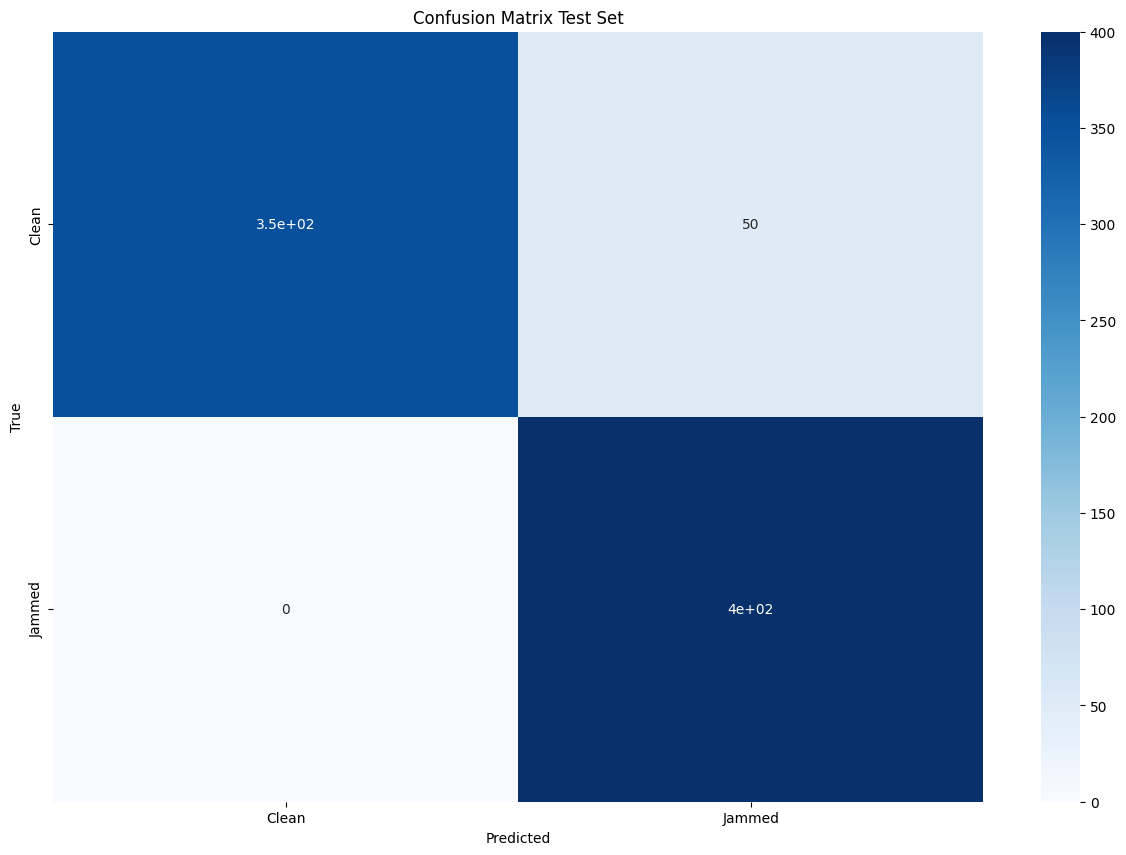

In [33]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold